# Klasifikasi Lokasi Indoor Berdasarkan Sinyal WiFi

## Kelompok 9:
- Yasinta Hutri Salamanang (18123001)
- Ashley Fadiya Hayaah (18123012)
- Naisya Sizzarra Rarasdewi (18123048)
- Ikbar Alif Sofiyan (18123050)

## 1. Import Libraries dan Setup

In [158]:
# core libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import hashlib
from math import sqrt
from pprint import pprint

# preprocessing dan pipeline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# model selection dan evaluasi
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# estimators
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# model metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# clustering untuk analisis area lemah
from sklearn.cluster import DBSCAN

# configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 2. Data Loading dan Initial Inspection

In [159]:
def load_and_inspect_data(file_path, dataset_name):
    """
    load dataset dengan comprehensive inspection untuk deteksi anomali
    """
    print(f"\nloading dan inspeksi {dataset_name}...")
    
    try:
        df = pd.read_csv(file_path)
        print(f"berhasil dimuat: {dataset_name}")
        print(f"shape: {df.shape}")
        
        # basic info
        print(f"\ninfo dasar {dataset_name}:")
        print(f"- jumlah kolom: {df.shape[1]}")
        print(f"- jumlah baris: {df.shape[0]}")
        print(f"- memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} mb")
        
        # check for missing values
        missing_count = df.isnull().sum().sum()
        print(f"- total missing values: {missing_count}")
        
        # identify column types
        wap_cols = [col for col in df.columns if col.startswith('WAP')]
        metadata_cols = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 
                         'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']
        
        print(f"- kolom wap: {len(wap_cols)}")
        print(f"- kolom metadata: {len([col for col in metadata_cols if col in df.columns])}")
        
        return df, wap_cols, metadata_cols
        
    except FileNotFoundError:
        print(f"error: file {file_path} tidak ditemukan!")
        print(f"pastikan file berada di path yang benar")
        return None, None, None
    except Exception as e:
        print(f"error loading {dataset_name}: {str(e)}")
        return None, None, None

In [160]:
# load datasets
# sesuaikan path sesuai lokasi file anda
training_data, wap_cols_train, metadata_cols = load_and_inspect_data(
    r'C:\Users\ASUS\Downloads\trainingData.csv', 'training data'
)

validation_data, wap_cols_val, _ = load_and_inspect_data(
    r'C:\Users\ASUS\Downloads\validationData.csv', 'validation data'  
)

# display basic information
if training_data is not None:
    print("\ntraining data sample:")
    display(training_data.head())
    
    print("\ntraining data info:")
    print(training_data.info())


loading dan inspeksi training data...
berhasil dimuat: training data
shape: (19937, 529)

info dasar training data:
- jumlah kolom: 529
- jumlah baris: 19937
- memory usage: 80.46 mb
- total missing values: 0
- kolom wap: 520
- kolom metadata: 9

loading dan inspeksi validation data...
berhasil dimuat: validation data
shape: (1111, 529)

info dasar validation data:
- jumlah kolom: 529
- jumlah baris: 1111
- memory usage: 4.48 mb
- total missing values: 0
- kolom wap: 520
- kolom metadata: 9

training data sample:


WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     -97     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP010  WAP011  WAP012  WAP013  WAP014  WAP015  WAP016  WAP017  WAP018  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP019  WAP020  WAP021  WAP022  WAP023  WAP024  WAP025  WAP026  WAP027  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP028  WAP029  WAP030  WAP031  WAP032  WAP033  WAP034  WAP035  WAP036  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     -92     100   
4     100     100     100     100     100     100     100     100     100   

   WAP037  WAP038  WAP039  WAP040  WAP041  WAP042  WAP043  WAP044  WAP045  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP046  WAP047  WAP048  WAP049  WAP050  WAP051  WAP052  WAP053  WAP054  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP055  WAP056  WAP057  WAP058  WAP059  WAP060  WAP061  WAP062  WAP063  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP064  WAP065  WAP066  WAP067  WAP068  WAP069  WAP070  WAP071  WAP072  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP073  WAP074  WAP075  WAP076  WAP077  WAP078  WAP079  WAP080  WAP081  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100   


training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB
None


## 3. Critical Data Quality Assessment

### 3.1 Data Leakage Detection

In [161]:
def detect_data_leakage(df1, df2, name1="training", name2="validation"):
    """
    deteksi kebocoran data antara training dan validation set
    """
    print(f"\ndeteksi kebocoran data: {name1} vs {name2}")
    print("="*50)
    
    if df1 is None or df2 is None:
        print("salah satu dataset tidak tersedia untuk analisis")
        return False
    
    # convert to string untuk exact matching
    df1_str = df1.astype(str)
    df2_str = df2.astype(str)
    
    # hash each row for efficient comparison
    df1_hashes = df1_str.apply(lambda x: hashlib.md5(''.join(x).encode()).hexdigest(), axis=1)
    df2_hashes = df2_str.apply(lambda x: hashlib.md5(''.join(x).encode()).hexdigest(), axis=1)
    
    # find overlapping rows
    common_hashes = set(df1_hashes) & set(df2_hashes)
    
    if len(common_hashes) > 0:
        print(f"kebocoran data terdeteksi!")
        print(f"     {len(common_hashes)} baris identik ditemukan antara {name1} dan {name2}")
        print(f"     persentase overlap: {len(common_hashes)/len(df1)*100:.2f}% dari {name1}")
        print(f"     persentase overlap: {len(common_hashes)/len(df2)*100:.2f}% dari {name2}")
        
        # show sample overlapping rows
        overlapping_indices_df1 = df1_hashes[df1_hashes.isin(common_hashes)].index[:3]
        
        print(f"\nsample overlapping rows dari {name1}:")
        display(df1.iloc[overlapping_indices_df1][['LONGITUDE', 'LATITUDE', 'FLOOR', 'SPACEID', 'TIMESTAMP']].head())
        
        print("\naksi diperlukan:")
        print("     - lakukan re-split dataset untuk memastikan independensi")
        print("     - evaluasi model saat ini tidak valid karena data leakage")
        
        return True
    else:
        print(f"tidak ada kebocoran data terdeteksi antara {name1} dan {name2}")
        return False

# jalankan deteksi data leakage
leakage_detected = detect_data_leakage(training_data, validation_data)


deteksi kebocoran data: training vs validation
tidak ada kebocoran data terdeteksi antara training dan validation


### 3.2 Coordinate System Analysis

In [162]:
def analyze_coordinate_system(df, dataset_name):
    """
    analisis sistem koordinat dan deteksi anomali
    """
    print(f"\nanalisis sistem koordinat: {dataset_name}")
    print("="*50)
    
    if df is None or 'LONGITUDE' not in df.columns or 'LATITUDE' not in df.columns:
        print("kolom koordinat tidak ditemukan")
        return
    
    lon_min, lon_max = df['LONGITUDE'].min(), df['LONGITUDE'].max()
    lat_min, lat_max = df['LATITUDE'].min(), df['LATITUDE'].max()
    
    print(f"rentang longitude: {lon_min:.6f} hingga {lon_max:.6f}")
    print(f"rentang latitude: {lat_min:.6f} hingga {lat_max:.6f}")
    
    # check if coordinates are in standard geographic range
    standard_geo = (-180 <= lon_min <= lon_max <= 180) and (-90 <= lat_min <= lat_max <= 90)
    
    if not standard_geo:
        print("anomali sistem koordinat terdeteksi!")
        print("     koordinat berada di luar rentang geografis standar:")
        print("     - longitude standar: -180° hingga +180°")  
        print("     - latitude standar: -90° hingga +90°")
        print("     kemungkinan menggunakan sistem koordinat lokal/proyeksi")
        print("     tidak dapat dipetakan langsung ke lokasi geografis global")
        print("     akan digunakan untuk positioning relatif dalam area survei")
    else:
        print("koordinat dalam rentang geografis standar")
    
    # calculate coordinate span
    lon_span = lon_max - lon_min
    lat_span = lat_max - lat_min
    print(f"span area: {lon_span:.2f} x {lat_span:.2f} unit koordinat")
    
    return not standard_geo

# analisis koordinat untuk kedua dataset
coord_anomaly_train = analyze_coordinate_system(training_data, "training data")
coord_anomaly_val = analyze_coordinate_system(validation_data, "validation data")


analisis sistem koordinat: training data
rentang longitude: -7691.338400 hingga -7300.818990
rentang latitude: 4864745.745016 hingga 4865016.687800
anomali sistem koordinat terdeteksi!
     koordinat berada di luar rentang geografis standar:
     - longitude standar: -180° hingga +180°
     - latitude standar: -90° hingga +90°
     kemungkinan menggunakan sistem koordinat lokal/proyeksi
     tidak dapat dipetakan langsung ke lokasi geografis global
     akan digunakan untuk positioning relatif dalam area survei
span area: 390.52 x 270.94 unit koordinat

analisis sistem koordinat: validation data
rentang longitude: -7695.938755 hingga -7299.786517
rentang latitude: 4864748.015485 hingga 4865017.364684
anomali sistem koordinat terdeteksi!
     koordinat berada di luar rentang geografis standar:
     - longitude standar: -180° hingga +180°
     - latitude standar: -90° hingga +90°
     kemungkinan menggunakan sistem koordinat lokal/proyeksi
     tidak dapat dipetakan langsung ke lokasi g

### 3.3 Duplicate Detection

In [163]:
def detect_duplicates(df, dataset_name):
    """
    deteksi dan analisis baris duplikat
    """
    print(f"\ndeteksi duplikasi data: {dataset_name}")
    print("="*50)
    
    if df is None:
        return 0, None
    
    total_rows = len(df)
    duplicate_rows = df.duplicated().sum()
    unique_rows = len(df.drop_duplicates())
    
    print(f"total baris: {total_rows:,}")
    print(f"baris duplikat: {duplicate_rows:,}")
    print(f"baris unik: {unique_rows:,}")
    print(f"persentase duplikasi: {duplicate_rows/total_rows*100:.2f}%")
    
    if duplicate_rows > 0:
        print(f"{duplicate_rows} baris duplikat ditemukan!")
        
        # show sample duplicates
        duplicated_samples = df[df.duplicated(keep=False)].head(6)
        print("\nsample baris duplikat:")
        display(duplicated_samples[['LONGITUDE', 'LATITUDE', 'FLOOR', 'SPACEID', 'USERID', 'TIMESTAMP']])
        
        return duplicate_rows, df.drop_duplicates().reset_index(drop=True)
    else:
        print("tidak ada duplikasi data ditemukan")
        return 0, df

# deteksi duplikasi
dup_count_train, training_clean = detect_duplicates(training_data, "training data")
dup_count_val, validation_clean = detect_duplicates(validation_data, "validation data")


deteksi duplikasi data: training data
total baris: 19,937
baris duplikat: 637
baris unik: 19,300
persentase duplikasi: 3.20%
637 baris duplikat ditemukan!

sample baris duplikat:


LONGITUDE      LATITUDE  FLOOR  SPACEID  USERID   TIMESTAMP
2334 -7352.33970  4.864838e+06      4      113       6  1371719975
2809 -7408.33887  4.864812e+06      3      253       6  1371715396
2824 -7352.33970  4.864838e+06      4      113       6  1371719973
2907 -7408.33887  4.864812e+06      3      253       6  1371715396
2920 -7352.33970  4.864838e+06      4      113       6  1371719973
3215 -7352.33970  4.864838e+06      4      113       6  1371719975


deteksi duplikasi data: validation data
total baris: 1,111
baris duplikat: 0
baris unik: 1,111
persentase duplikasi: 0.00%
tidak ada duplikasi data ditemukan


### 3.4 WAP Sparsity Analysis

In [164]:
def analyze_wap_sparsity(df, wap_cols, dataset_name, sample_size=10):
    """
    analisis sparsitas data wap dan distribusi sinyal
    """
    print(f"\nanalisis sparsitas data wap: {dataset_name}")
    print("="*50)
    
    if df is None or not wap_cols:
        return 0, 0, 0
    
    wap_data = df[wap_cols]
    
    # analisis nilai 100 (no signal)
    total_cells = wap_data.shape[0] * wap_data.shape[1]
    no_signal_cells = (wap_data == 100).sum().sum()
    sparsity_percentage = no_signal_cells / total_cells * 100
    
    print(f"total sel wap: {total_cells:,}")
    print(f"sel dengan nilai 100 (no signal): {no_signal_cells:,}")
    print(f"tingkat sparsitas: {sparsity_percentage:.2f}%")
    
    # analisis per wap
    wap_100_percentage = (wap_data == 100).mean() * 100
    completely_sparse_waps = (wap_100_percentage == 100).sum()
    mostly_sparse_waps = (wap_100_percentage > 95).sum()
    
    print(f"wap yang 100% bernilai 100: {completely_sparse_waps}")
    print(f"wap yang >95% bernilai 100: {mostly_sparse_waps}")
    
    # analisis distribusi rssi
    rssi_data = wap_data[wap_data != 100]
    if len(rssi_data.values.flatten()) > 0:
        rssi_values = rssi_data.values.flatten()
        rssi_values = rssi_values[~pd.isna(rssi_values)]
        
        if len(rssi_values) > 0:
            print(f"rentang rssi: {rssi_values.min():.0f} hingga {rssi_values.max():.0f} dbm")
            print(f"rata-rata rssi: {rssi_values.mean():.1f} dbm")
            print(f"median rssi: {np.median(rssi_values):.1f} dbm")
    
    return sparsity_percentage, completely_sparse_waps, mostly_sparse_waps

# analisis sparsitas wap
if training_clean is not None and wap_cols_train:
    sparsity_train, sparse_waps_train, mostly_sparse_train = analyze_wap_sparsity(
        training_clean, wap_cols_train, "training data"
    )

if validation_clean is not None and wap_cols_val:
    sparsity_val, sparse_waps_val, mostly_sparse_val = analyze_wap_sparsity(
        validation_clean, wap_cols_val, "validation data"
    )


analisis sparsitas data wap: training data
total sel wap: 10,036,000
sel dengan nilai 100 (no signal): 9,690,920
tingkat sparsitas: 96.56%
wap yang 100% bernilai 100: 55
wap yang >95% bernilai 100: 413
rentang rssi: -104 hingga 0 dbm
rata-rata rssi: -78.6 dbm
median rssi: -82.0 dbm

analisis sparsitas data wap: validation data
total sel wap: 577,720
sel dengan nilai 100 (no signal): 559,416
tingkat sparsitas: 96.83%
wap yang 100% bernilai 100: 153
wap yang >95% bernilai 100: 385
rentang rssi: -102 hingga -34 dbm
rata-rata rssi: -77.7 dbm
median rssi: -80.0 dbm


## 4. Data Cleaning & Preprocessing

In [165]:
def clean_and_preprocess_data(df, wap_cols, metadata_cols, dataset_name):
    """
    comprehensive data cleaning dan preprocessing
    """
    print(f"\ndata cleaning & preprocessing: {dataset_name}")
    print("="*50)
    
    if df is None:
        return None, None
    
    df_clean = df.copy()
    original_rows = len(df_clean)
    
    # 1. remove duplicates
    print("1. memastikan tidak ada duplikasi...")
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
    rows_after_dedup = len(df_clean)
    if original_rows - rows_after_dedup > 0:
        print(f"     baris duplikat dihapus: {original_rows - rows_after_dedup}")
    else:
        print("     tidak ada duplikasi tambahan ditemukan")
    
    # 2. standardize spaceid format
    print("2. standardisasi format spaceid...")
    if 'SPACEID' in df_clean.columns:
        df_clean['SPACEID_original'] = df_clean['SPACEID'].copy()
        
        # convert to numeric, handling leading zeros
        df_clean['SPACEID'] = pd.to_numeric(df_clean['SPACEID'], errors='coerce')
        
        # check for conversion issues
        conversion_issues = df_clean['SPACEID'].isna().sum()
        if conversion_issues > 0:
            print(f"     {conversion_issues} spaceid tidak dapat dikonversi ke numerik")
            # keep original for those that couldn't be converted
            mask = df_clean['SPACEID'].isna()
            df_clean.loc[mask, 'SPACEID'] = df_clean.loc[mask, 'SPACEID_original']
        
        print(f"     spaceid berhasil distandardisasi")
    
    # 3. handle wap signals (replace 100 with appropriate noise floor)
    print("3. preprocessing sinyal wap...")
    if wap_cols:
        wap_data = df_clean[wap_cols].copy()
        
        # replace 100 (no signal) with noise floor value
        noise_floor = -105  # typical wifi noise floor
        wap_data = wap_data.replace(100, noise_floor)
        
        # update dataframe
        df_clean[wap_cols] = wap_data
        
        print(f"     nilai 100 diganti dengan noise floor ({noise_floor} dbm)")
    
    # 4. remove completely uninformative waps
    print("4. menghapus wap yang tidak informatif...")
    if wap_cols:
        original_wap_count = len(wap_cols)
        
        # identify waps that are always at noise floor
        uninformative_waps = []
        for wap in wap_cols:
            if (df_clean[wap] == -105).all():
                uninformative_waps.append(wap)
        
        if uninformative_waps:
            df_clean = df_clean.drop(columns=uninformative_waps)
            remaining_wap_cols = [col for col in wap_cols if col not in uninformative_waps]
            print(f"     {len(uninformative_waps)} wap tidak informatif dihapus")
            print(f"     wap tersisa: {len(remaining_wap_cols)} dari {original_wap_count}")
        else:
            remaining_wap_cols = wap_cols
            print("     semua wap memiliki informasi yang berguna")
    else:
        remaining_wap_cols = []
    
    print(f"\ndata cleaning selesai untuk {dataset_name}")
    print(f"     baris final: {len(df_clean):,} (dari {original_rows:,} awal)")
    print(f"     kolom wap tersisa: {len(remaining_wap_cols)}")
    
    return df_clean, remaining_wap_cols

# apply cleaning
if training_clean is not None:
    training_final, wap_cols_clean = clean_and_preprocess_data(
        training_clean, wap_cols_train, metadata_cols, "training data"
    )

if validation_clean is not None:
    validation_final, wap_cols_val_clean = clean_and_preprocess_data(
        validation_clean, wap_cols_val, metadata_cols, "validation data"
    )


data cleaning & preprocessing: training data
1. memastikan tidak ada duplikasi...
     tidak ada duplikasi tambahan ditemukan
2. standardisasi format spaceid...
     spaceid berhasil distandardisasi
3. preprocessing sinyal wap...
     nilai 100 diganti dengan noise floor (-105 dbm)
4. menghapus wap yang tidak informatif...
     55 wap tidak informatif dihapus
     wap tersisa: 465 dari 520

data cleaning selesai untuk training data
     baris final: 19,300 (dari 19,300 awal)
     kolom wap tersisa: 465

data cleaning & preprocessing: validation data
1. memastikan tidak ada duplikasi...
     tidak ada duplikasi tambahan ditemukan
2. standardisasi format spaceid...
     spaceid berhasil distandardisasi
3. preprocessing sinyal wap...
     nilai 100 diganti dengan noise floor (-105 dbm)
4. menghapus wap yang tidak informatif...
     153 wap tidak informatif dihapus
     wap tersisa: 367 dari 520

data cleaning selesai untuk validation data
     baris final: 1,111 (dari 1,111 awal)
     ko

## 5. Feature Engineering dan Advanced Preprocessing

In [166]:
# pastikan variabel training_final ada (gunakan training_clean sebagai fallback)
if 'training_final' not in locals() and training_clean is not None:
    training_final = training_clean.copy()
    wap_cols_clean = wap_cols_train

# feature engineering - mengambil semua kolom wap
wap_columns = [col for col in training_final.columns if col.startswith('WAP')]

# salin data wap dan ganti nilai 100 menjadi -105
X = training_final[wap_columns]
X_clean = X.replace(100, -105)

# gabungkan kembali dengan kolom non-wap
non_wap_columns = [col for col in training_final.columns if col not in wap_columns]
wifi_clean = pd.concat([X_clean.reset_index(drop=True), training_final[non_wap_columns].reset_index(drop=True)], axis=1)

print(f"shape setelah feature engineering: {wifi_clean.shape}")
print(f"jumlah wap columns: {len(wap_columns)}")

shape setelah feature engineering: (19300, 475)
jumlah wap columns: 465


In [167]:
# hapus baris yang seluruh sinyalnya -105 (tidak ada sinyal terdeteksi sama sekali)
mask_all_missing = (X_clean == -105).all(axis=1)
wifi_clean = wifi_clean[~mask_all_missing].reset_index(drop=True)
X_clean = X_clean[~mask_all_missing].reset_index(drop=True)

# hapus baris yang memiliki lebih dari 95% sinyal -105
threshold = int(0.95 * X_clean.shape[1])
mask_mostly_missing = (X_clean == -105).sum(axis=1) > threshold

rows_before = wifi_clean.shape[0]
wifi_clean = wifi_clean[~mask_mostly_missing].reset_index(drop=True)
X_clean = X_clean[~mask_mostly_missing].reset_index(drop=True)
rows_after = wifi_clean.shape[0]

print(f"jumlah baris sebelum: {rows_before}")
print(f"jumlah baris sesudah: {rows_after}")
print(f"jumlah baris dihapus (>95% sinyal -105): {rows_before - rows_after}")

jumlah baris sebelum: 19227
jumlah baris sesudah: 3677
jumlah baris dihapus (>95% sinyal -105): 15550


statistik sinyal terkuat per baris:
count    3677.000000
mean      -53.092195
std        14.830542
min       -83.000000
25%       -62.000000
50%       -55.000000
75%       -46.000000
max         0.000000
dtype: float64


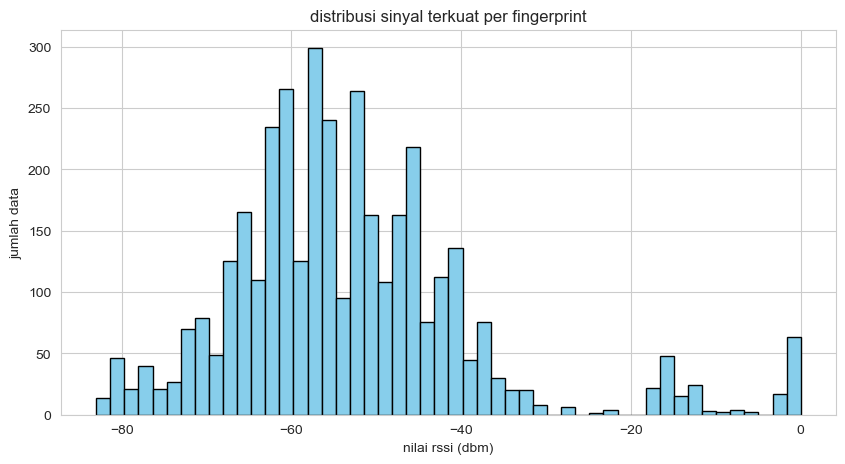

In [168]:
# analisis sinyal terkuat per baris (rssi maksimum)
strongest_signal = X_clean.max(axis=1)

# statistik deskriptif dari sinyal terkuat
print("statistik sinyal terkuat per baris:")
print(strongest_signal.describe())

# visualisasi distribusi sinyal terkuat
plt.figure(figsize=(10, 5))
plt.hist(strongest_signal, bins=50, color='skyblue', edgecolor='black')
plt.title('distribusi sinyal terkuat per fingerprint')
plt.xlabel('nilai rssi (dbm)')
plt.ylabel('jumlah data')
plt.grid(True)
plt.show()

## 6. Exploratory Data Analysis (EDA)

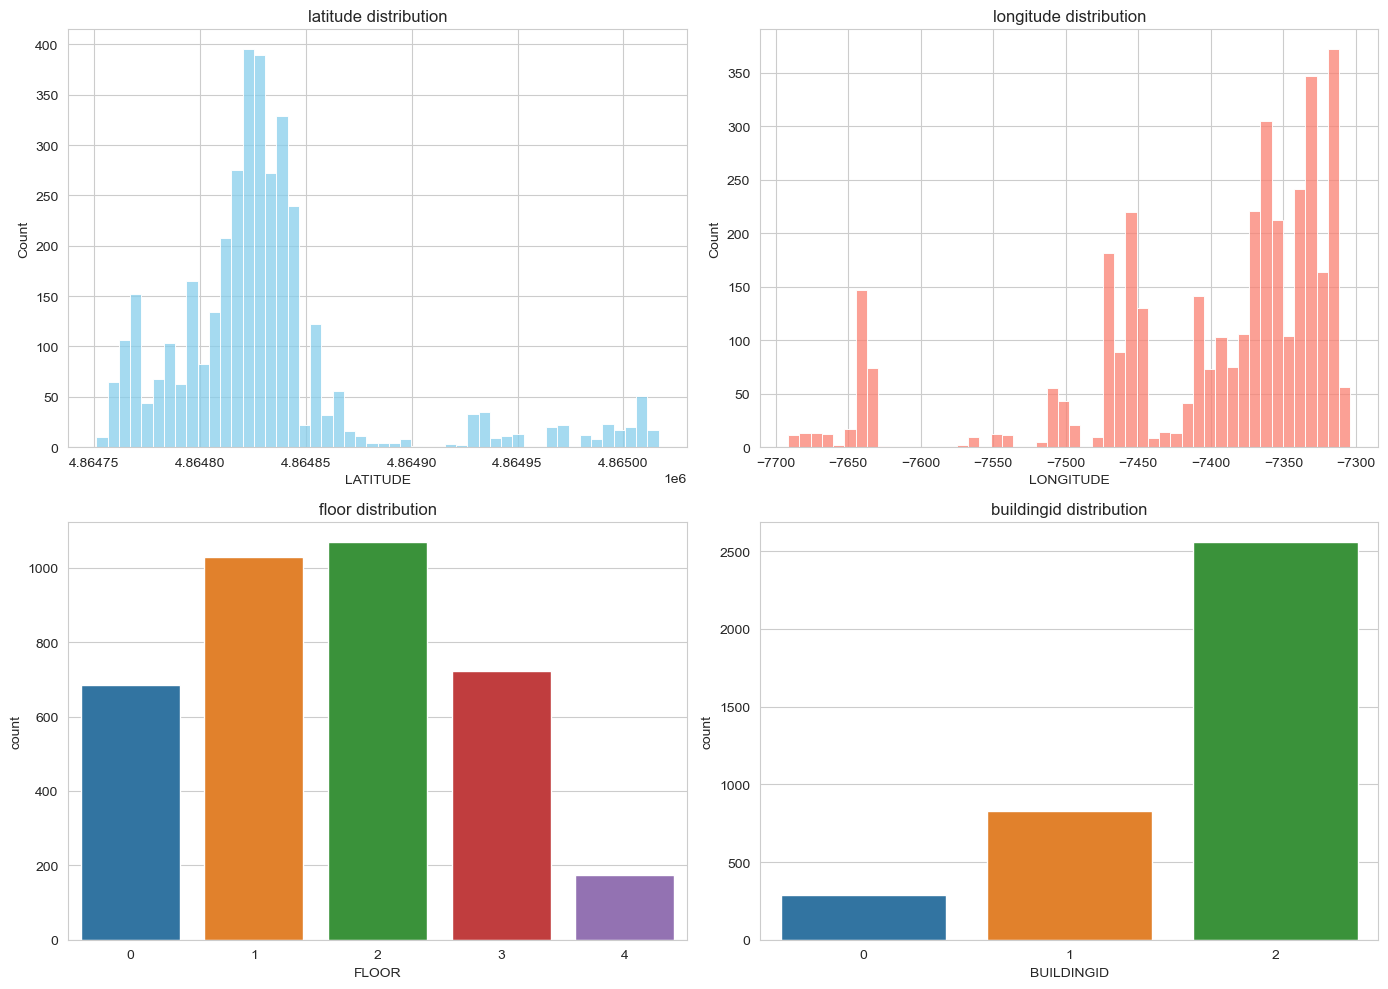

In [169]:
# target variable distribution dan analisis umum
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(wifi_clean['LATITUDE'], bins=50, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('latitude distribution')

sns.histplot(wifi_clean['LONGITUDE'], bins=50, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('longitude distribution')

sns.countplot(x='FLOOR', data=wifi_clean, ax=axes[1, 0])
axes[1, 0].set_title('floor distribution')

sns.countplot(x='BUILDINGID', data=wifi_clean, ax=axes[1, 1])
axes[1, 1].set_title('buildingid distribution')

plt.tight_layout()
plt.show()

## 7. Model Building dan Training Pipeline

In [170]:
# preprocessing data untuk pemodelan
# bangun fitur & label
wap_cols = [c for c in wifi_clean.columns if c.startswith('WAP')]
extra_cols = ['LONGITUDE', 'LATITUDE', 'FLOOR',
              'BUILDINGID', 'SPACEID', 'USERID', 'PHONEID']
feat_cols = wap_cols + [col for col in extra_cols if col in wifi_clean.columns]

# ganti nilai nan dengan -105
X = wifi_clean[feat_cols].fillna(-105)
y = wifi_clean['FLOOR'].squeeze()  # label 1-d

print(f"shape fitur: {X.shape}")
print(f"distribusi target (floor): {y.value_counts().sort_index()}")

shape fitur: (3677, 472)
distribusi target (floor): FLOOR
0     684
1    1028
2    1070
3     722
4     173
Name: count, dtype: int64


In [171]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("train shape :", X_train.shape)
print("test  shape :", X_test.shape)
print("distribusi y_train:", y_train.value_counts().sort_index())
print("distribusi y_test:", y_test.value_counts().sort_index())

train shape : (2941, 472)
test  shape : (736, 472)
distribusi y_train: FLOOR
0    547
1    822
2    856
3    578
4    138
Name: count, dtype: int64
distribusi y_test: FLOOR
0    137
1    206
2    214
3    144
4     35
Name: count, dtype: int64


### 7.1 Pipeline Setup dan Basic Model Training

In [172]:
# pipeline (imputer → scaler → model)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # tangani nan
    ('scaler',  StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_pipe, numeric_cols)],
    remainder='drop'    # kolom string (jika ada) otomatis dibuang
)

# basic knn pipeline
knn_pipe = Pipeline([
    ('prep',  preprocess),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# training basic model
print("training basic knn model...")
knn_pipe.fit(X_train, y_train)

# prediksi & evaluasi
y_pred_basic = knn_pipe.predict(X_test)

acc_basic = accuracy_score(y_test, y_pred_basic)
prec_basic = precision_score(y_test, y_pred_basic, average='weighted', zero_division=0)
rec_basic = recall_score(y_test, y_pred_basic, average='weighted', zero_division=0)
f1_basic = f1_score(y_test, y_pred_basic, average='weighted', zero_division=0)

print("\nevaluasi basic knn model:")
print(f"accuracy : {acc_basic:.4f} ({acc_basic*100:.2f}%)")
print(f"precision: {prec_basic:.4f} ({prec_basic*100:.2f}%)")
print(f"recall   : {rec_basic:.4f} ({rec_basic*100:.2f}%)")
print(f"f1 score : {f1_basic:.4f} ({f1_basic*100:.2f}%)")

training basic knn model...

evaluasi basic knn model:
accuracy : 0.9878 (98.78%)
precision: 0.9880 (98.80%)
recall   : 0.9878 (98.78%)
f1 score : 0.9878 (98.78%)


### 7.2 Optimized KNN dengan Grid Search

In [173]:
# grid search untuk knn optimization
knn = KNeighborsClassifier()

pipe_knn = Pipeline([
    ('prep',  preprocess),
    ('model', knn)
])

# parameter grid untuk knn
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights'    : ['uniform', 'distance'],
    'model__metric'     : ['euclidean', 'manhattan', 'minkowski']
}

print("menjalankan grid search untuk knn optimization...")
grid_search_knn = GridSearchCV(
    estimator = pipe_knn,
    param_grid = param_grid_knn,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    scoring = 'accuracy'
)

# fit grid search
grid_search_knn.fit(X_train, y_train)

print("best parameters knn:", grid_search_knn.best_params_)
print("best cv score knn   :", f"{grid_search_knn.best_score_:.4f} ({grid_search_knn.best_score_*100:.2f}%)")

# evaluasi model terbaik knn
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
rec_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print("\nevaluasi optimized knn model:")
print(f"accuracy : {acc_knn:.4f} ({acc_knn*100:.2f}%)")
print(f"precision: {prec_knn:.4f} ({prec_knn*100:.2f}%)")
print(f"recall   : {rec_knn:.4f} ({rec_knn*100:.2f}%)")
print(f"f1 score : {f1_knn:.4f} ({f1_knn*100:.2f}%)")

menjalankan grid search untuk knn optimization...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
best parameters knn: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'distance'}
best cv score knn   : 0.9939 (99.39%)

evaluasi optimized knn model:
accuracy : 0.9973 (99.73%)
precision: 0.9973 (99.73%)
recall   : 0.9973 (99.73%)
f1 score : 0.9973 (99.73%)


### 7.3 Random Forest Model

In [174]:
# random forest pipeline
rf_pipeline = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier(random_state=42))
])

# latih model random forest
print("training random forest model...")
rf_pipeline.fit(X_train, y_train)

# prediksi
y_pred_rf = rf_pipeline.predict(X_test)

# evaluasi
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print("\nevaluasi random forest model:")
print(f"accuracy : {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"precision: {prec_rf:.4f} ({prec_rf*100:.2f}%)")
print(f"recall   : {rec_rf:.4f} ({rec_rf*100:.2f}%)")
print(f"f1 score : {f1_rf:.4f} ({f1_rf*100:.2f}%)")

training random forest model...

evaluasi random forest model:
accuracy : 1.0000 (100.00%)
precision: 1.0000 (100.00%)
recall   : 1.0000 (100.00%)
f1 score : 1.0000 (100.00%)


### 7.4 Optimized Random Forest dengan Grid Search

In [175]:
# parameter grid untuk random forest
param_grid_rf = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

# pipeline untuk random forest
pipeline_rf_opt = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier(random_state=42))
])

print("menjalankan grid search untuk random forest optimization...")
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf_opt,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# latih model
grid_search_rf.fit(X_train, y_train)

print("best parameters rf:", grid_search_rf.best_params_)
print("best cv score rf  :", f"{grid_search_rf.best_score_:.4f} ({grid_search_rf.best_score_*100:.2f}%)")

# evaluasi model terbaik rf
best_rf = grid_search_rf.best_estimator_
y_pred_rf_opt = best_rf.predict(X_test)

acc_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
prec_rf_opt = precision_score(y_test, y_pred_rf_opt, average='weighted')
rec_rf_opt = recall_score(y_test, y_pred_rf_opt, average='weighted')
f1_rf_opt = f1_score(y_test, y_pred_rf_opt, average='weighted')

print("\nevaluasi optimized random forest model:")
print(f"accuracy : {acc_rf_opt:.4f} ({acc_rf_opt*100:.2f}%)")
print(f"precision: {prec_rf_opt:.4f} ({prec_rf_opt*100:.2f}%)")
print(f"recall   : {rec_rf_opt:.4f} ({rec_rf_opt*100:.2f}%)")
print(f"f1 score : {f1_rf_opt:.4f} ({f1_rf_opt*100:.2f}%)")

menjalankan grid search untuk random forest optimization...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
best parameters rf: {'model__max_depth': 30, 'model__min_samples_split': 2, 'model__n_estimators': 150}
best cv score rf  : 0.9980 (99.80%)

evaluasi optimized random forest model:
accuracy : 1.0000 (100.00%)
precision: 1.0000 (100.00%)
recall   : 1.0000 (100.00%)
f1 score : 1.0000 (100.00%)


### 7.5 Gradient Boosting Model

In [176]:
# gradient boosting pipeline
gb_pipeline = Pipeline([
    ('prep', preprocess),
    ('model', GradientBoostingClassifier(random_state=42))
])

# training
print("training gradient boosting model...")
gb_pipeline.fit(X_train, y_train)

# prediksi
y_pred_gb = gb_pipeline.predict(X_test)

# evaluasi
acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average='weighted', zero_division=0)
rec_gb = recall_score(y_test, y_pred_gb, average='weighted', zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)

print("\nevaluasi gradient boosting model:")
print(f"accuracy : {acc_gb:.4f} ({acc_gb*100:.2f}%)")
print(f"precision: {prec_gb:.4f} ({prec_gb*100:.2f}%)")
print(f"recall   : {rec_gb:.4f} ({rec_gb*100:.2f}%)")
print(f"f1 score : {f1_gb:.4f} ({f1_gb*100:.2f}%)")

training gradient boosting model...

evaluasi gradient boosting model:
accuracy : 1.0000 (100.00%)
precision: 1.0000 (100.00%)
recall   : 1.0000 (100.00%)
f1 score : 1.0000 (100.00%)


### 7.6 Optimized Gradient Boosting dengan Randomized Search

In [177]:
# randomized search untuk gradient boosting (lebih efisien untuk parameter space yang besar)
param_grid_gb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.05, 0.1, 0.15],
    'model__max_depth': [3, 5, 7]
}

gb_pipe_opt = Pipeline([
    ('prep', preprocess),
    ('model', GradientBoostingClassifier(random_state=42))
])

print("menjalankan randomized search untuk gradient boosting optimization...")
random_search_gb = RandomizedSearchCV(
    estimator=gb_pipe_opt,
    param_distributions=param_grid_gb,
    n_iter=15,  # uji 15 kombinasi acak
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

random_search_gb.fit(X_train, y_train)

print("best parameters gb:", random_search_gb.best_params_)
print("best score gb     :", f"{random_search_gb.best_score_:.4f} ({random_search_gb.best_score_*100:.2f}%)")

# evaluasi model terbaik gb
best_gb = random_search_gb.best_estimator_
y_pred_gb_opt = best_gb.predict(X_test)

acc_gb_opt = accuracy_score(y_test, y_pred_gb_opt)
prec_gb_opt = precision_score(y_test, y_pred_gb_opt, average='weighted')
rec_gb_opt = recall_score(y_test, y_pred_gb_opt, average='weighted')
f1_gb_opt = f1_score(y_test, y_pred_gb_opt, average='weighted')

print("\nevaluasi optimized gradient boosting model:")
print(f"accuracy : {acc_gb_opt:.4f} ({acc_gb_opt*100:.2f}%)")
print(f"precision: {prec_gb_opt:.4f} ({prec_gb_opt*100:.2f}%)")
print(f"recall   : {rec_gb_opt:.4f} ({rec_gb_opt*100:.2f}%)")
print(f"f1 score : {f1_gb_opt:.4f} ({f1_gb_opt*100:.2f}%)")

menjalankan randomized search untuk gradient boosting optimization...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
best parameters gb: {'model__n_estimators': 150, 'model__max_depth': 7, 'model__learning_rate': 0.05}
best score gb     : 1.0000 (100.00%)

evaluasi optimized gradient boosting model:
accuracy : 1.0000 (100.00%)
precision: 1.0000 (100.00%)
recall   : 1.0000 (100.00%)
f1 score : 1.0000 (100.00%)


## 8. Model Performance Comparison

In [178]:
# membandingkan semua model
model_comparison = pd.DataFrame({
    'model': [
        'basic knn',
        'optimized knn', 
        'basic random forest',
        'optimized random forest',
        'basic gradient boosting',
        'optimized gradient boosting'
    ],
    'accuracy (%)': [
        acc_basic*100,
        acc_knn*100,
        acc_rf*100,
        acc_rf_opt*100,
        acc_gb*100,
        acc_gb_opt*100
    ],
    'precision (%)': [
        prec_basic*100,
        prec_knn*100,
        prec_rf*100,
        prec_rf_opt*100,
        prec_gb*100,
        prec_gb_opt*100
    ],
    'recall (%)': [
        rec_basic*100,
        rec_knn*100,
        rec_rf*100,
        rec_rf_opt*100,
        rec_gb*100,
        rec_gb_opt*100
    ],
    'f1 score (%)': [
        f1_basic*100,
        f1_knn*100,
        f1_rf*100,
        f1_rf_opt*100,
        f1_gb*100,
        f1_gb_opt*100
    ]
})

print("\nperbandingan performance semua model:")
print("="*70)
# format angka untuk readability
pd.options.display.float_format = '{:.2f}'.format
display(model_comparison)

# reset format
pd.reset_option('display.float_format')

# identifikasi model terbaik
best_model_idx = model_comparison['accuracy (%)'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'model']
best_accuracy = model_comparison.loc[best_model_idx, 'accuracy (%)']

print(f"\nmodel terbaik: {best_model_name}")
print(f"akurasi terbaik: {best_accuracy:.2f}%")


perbandingan performance semua model:


model  accuracy (%)  precision (%)  recall (%)  \
0                    basic knn         98.78          98.80       98.78   
1                optimized knn         99.73          99.73       99.73   
2          basic random forest        100.00         100.00      100.00   
3      optimized random forest        100.00         100.00      100.00   
4      basic gradient boosting        100.00         100.00      100.00   
5  optimized gradient boosting        100.00         100.00      100.00   

   f1 score (%)  
0         98.78  
1         99.73  
2        100.00  
3        100.00  
4        100.00  
5        100.00


model terbaik: basic random forest
akurasi terbaik: 100.00%


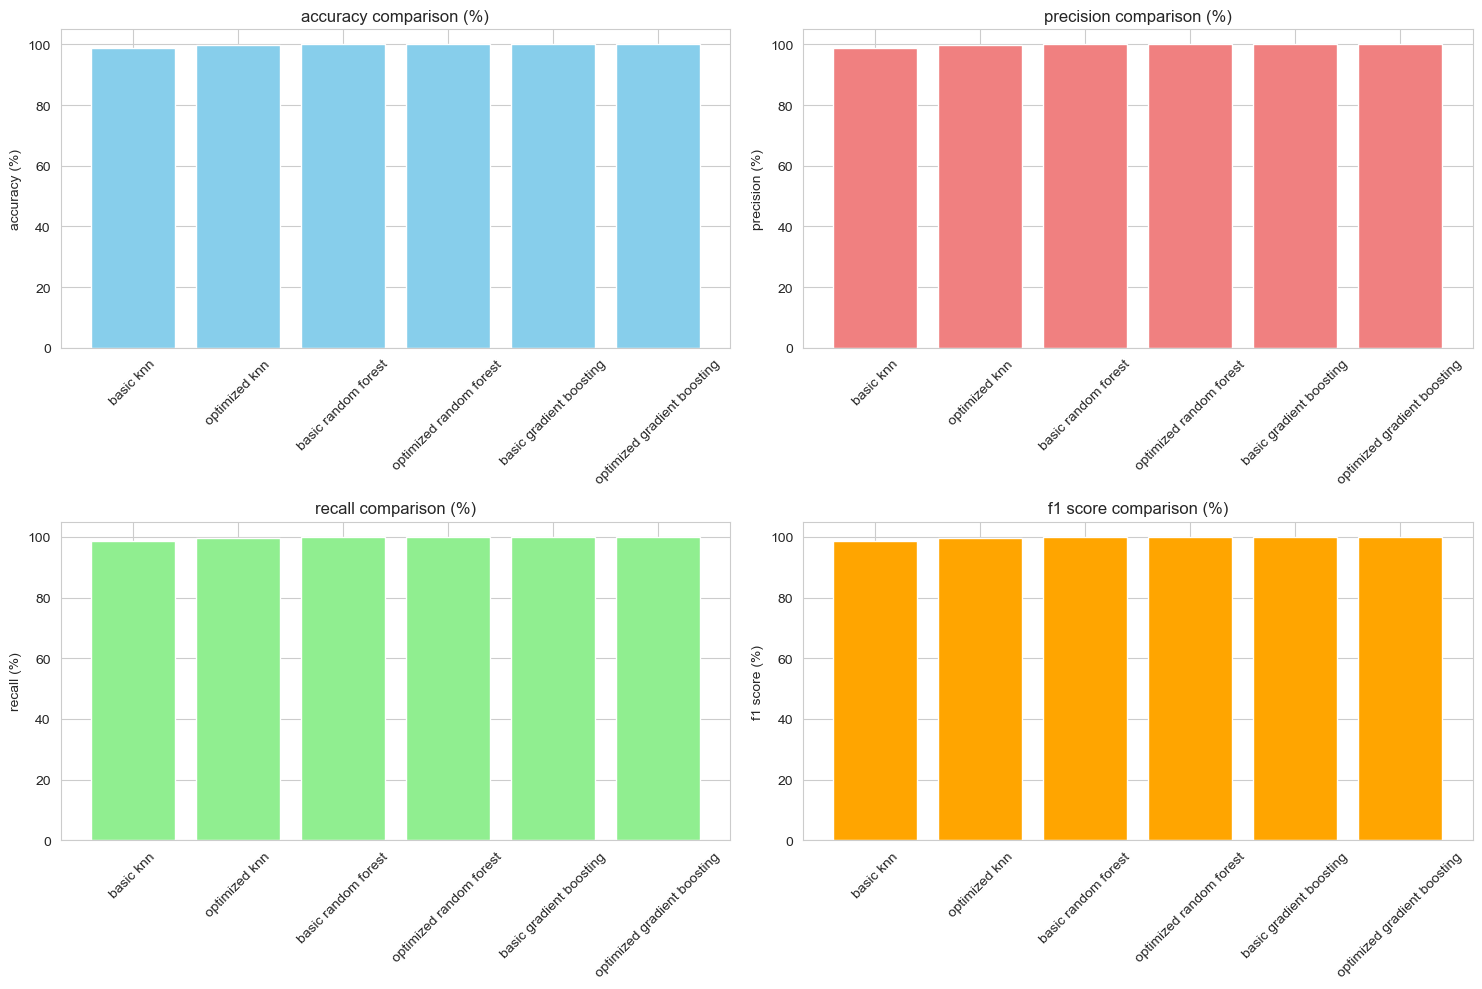

In [179]:
# visualisasi perbandingan model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# accuracy comparison
axes[0, 0].bar(model_comparison['model'], model_comparison['accuracy (%)'], color='skyblue')
axes[0, 0].set_title('accuracy comparison (%)')
axes[0, 0].set_ylabel('accuracy (%)')
axes[0, 0].tick_params(axis='x', rotation=45)

# precision comparison
axes[0, 1].bar(model_comparison['model'], model_comparison['precision (%)'], color='lightcoral')
axes[0, 1].set_title('precision comparison (%)')
axes[0, 1].set_ylabel('precision (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

# recall comparison
axes[1, 0].bar(model_comparison['model'], model_comparison['recall (%)'], color='lightgreen')
axes[1, 0].set_title('recall comparison (%)')
axes[1, 0].set_ylabel('recall (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# f1 score comparison
axes[1, 1].bar(model_comparison['model'], model_comparison['f1 score (%)'], color='orange')
axes[1, 1].set_title('f1 score comparison (%)')
axes[1, 1].set_ylabel('f1 score (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Confusion Matrix untuk Model Terbaik

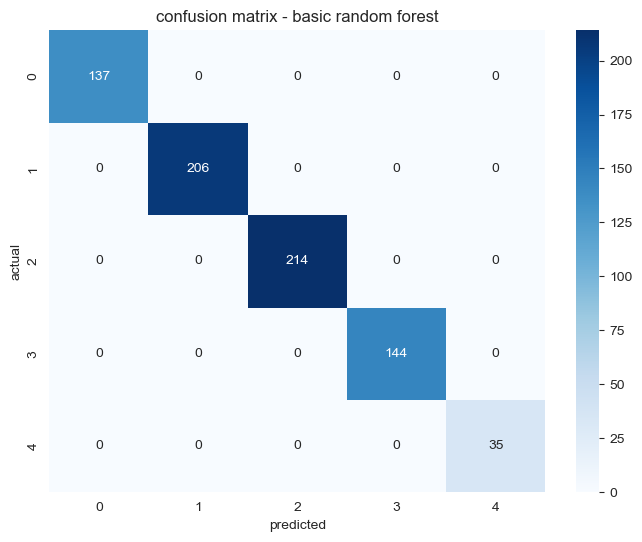


classification report - basic random forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       206
           2       1.00      1.00      1.00       214
           3       1.00      1.00      1.00       144
           4       1.00      1.00      1.00        35

    accuracy                           1.00       736
   macro avg       1.00      1.00      1.00       736
weighted avg       1.00      1.00      1.00       736



In [180]:
# confusion matrix untuk model terbaik berdasarkan akurasi
if best_model_name == 'optimized knn':
    y_pred_best = y_pred_knn
    best_estimator = best_knn
elif best_model_name == 'optimized random forest':
    y_pred_best = y_pred_rf_opt
    best_estimator = best_rf
elif best_model_name == 'optimized gradient boosting':
    y_pred_best = y_pred_gb_opt
    best_estimator = best_gb
elif best_model_name == 'basic random forest':
    y_pred_best = y_pred_rf
    best_estimator = rf_pipeline
elif best_model_name == 'basic gradient boosting':
    y_pred_best = y_pred_gb
    best_estimator = gb_pipeline
else:  # basic knn
    y_pred_best = y_pred_basic
    best_estimator = knn_pipe

# confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title(f'confusion matrix - {best_model_name}')
plt.show()

# classification report
print(f"\nclassification report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, zero_division=0))

## 10. Analisis Area Sinyal Lemah dan Optimasi Jaringan

In [205]:
# identifikasi area dengan sinyal lemah
wap_cols_analysis = [col for col in wifi_clean.columns if col.startswith('WAP')]

# ganti nilai 100 (tidak ada sinyal) dengan nan untuk analisis
wifi_rssi = wifi_clean[wap_cols_analysis].replace(100, np.nan)

# deteksi sinyal lemah (rata-rata sinyal < -80 dbm)
weak_threshold = -80
weak_mask = wifi_rssi.mean(axis=1) < weak_threshold

# simpan area dengan sinyal lemah
# ambil kolom WAP + metadata
cols_to_keep = ['USERID', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID'] + wap_cols_analysis
weak_signal_areas = wifi_clean.loc[weak_mask, cols_to_keep]

print(f"\nanalisis area sinyal lemah:")
print(f"threshold sinyal lemah: {weak_threshold} dbm")
print(f"jumlah area dengan sinyal lemah: {len(weak_signal_areas)}")
print(f"persentase area lemah: {len(weak_signal_areas)/len(wifi_clean)*100:.2f}%")

if len(weak_signal_areas) > 0:
    print("\ndistribusi area lemah per lantai:")
    print(weak_signal_areas['FLOOR'].value_counts().sort_index())
    
    print("\ndistribusi area lemah per gedung:")
    print(weak_signal_areas['BUILDINGID'].value_counts().sort_index())


analisis area sinyal lemah:
threshold sinyal lemah: -80 dbm
jumlah area dengan sinyal lemah: 3677
persentase area lemah: 100.00%

distribusi area lemah per lantai:
FLOOR
0     684
1    1028
2    1070
3     722
4     173
Name: count, dtype: int64

distribusi area lemah per gedung:
BUILDINGID
0     290
1     826
2    2561
Name: count, dtype: int64


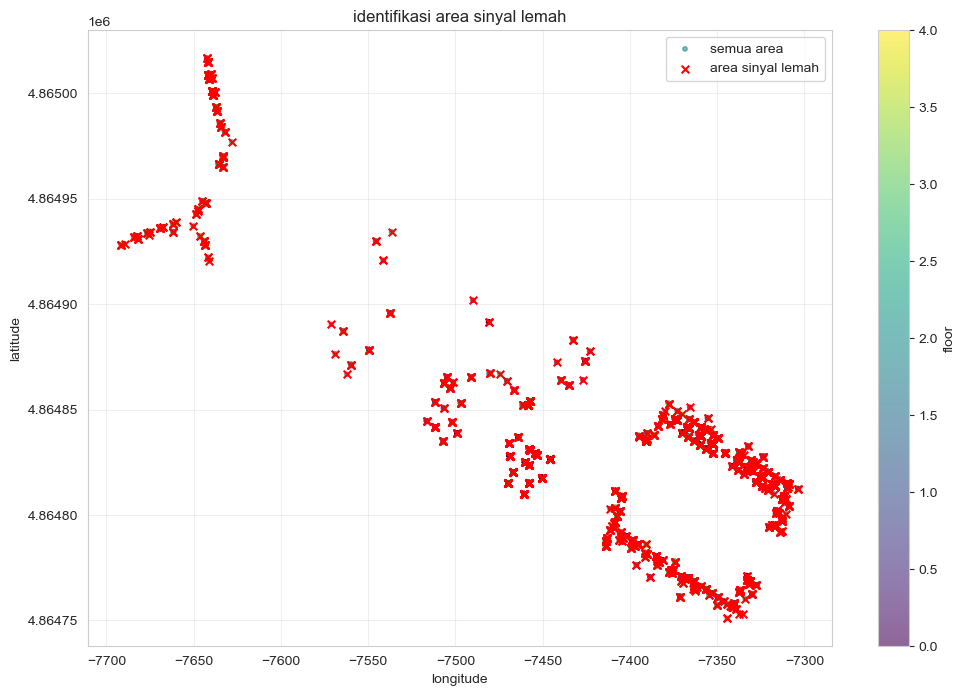

In [182]:
# visualisasi area sinyal lemah
if len(weak_signal_areas) > 0:
    plt.figure(figsize=(12, 8))
    
    # plot semua titik lokasi
    scatter = plt.scatter(
        wifi_clean['LONGITUDE'],
        wifi_clean['LATITUDE'],
        c=wifi_clean['FLOOR'],
        cmap='viridis',
        s=10,
        alpha=0.6,
        label='semua area'
    )
    
    # highlight area dengan sinyal lemah
    plt.scatter(
        weak_signal_areas['LONGITUDE'],
        weak_signal_areas['LATITUDE'],
        s=30,
        c='red',
        marker='x',
        label='area sinyal lemah'
    )
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('identifikasi area sinyal lemah')
    plt.legend()
    plt.colorbar(scatter, label='floor')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("tidak ada area dengan sinyal lemah terdeteksi")


clustering area sinyal lemah:
jumlah cluster ditemukan: 65
jumlah noise points: 21

rekomendasi penempatan access point:
  cluster 0: longitude=-7458.22, latitude=4864852.68, floor=2, coverage=97 points
  cluster 1: longitude=-7466.29, latitude=4864859.34, floor=2, coverage=10 points
  cluster 2: longitude=-7331.41, latitude=4864768.38, floor=3, coverage=85 points
  cluster 3: longitude=-7335.65, latitude=4864763.59, floor=3, coverage=44 points
  cluster 4: longitude=-7356.79, latitude=4864764.33, floor=1, coverage=190 points
  cluster 5: longitude=-7403.82, latitude=4864790.26, floor=3, coverage=241 points
  cluster 6: longitude=-7375.88, latitude=4864774.30, floor=3, coverage=45 points
  cluster 7: longitude=-7537.25, latitude=4864895.74, floor=1, coverage=8 points
  cluster 8: longitude=-7383.99, latitude=4864778.96, floor=1, coverage=45 points
  cluster 9: longitude=-7480.43, latitude=4864867.13, floor=2, coverage=6 points
  cluster 10: longitude=-7511.76, latitude=4864841.66, flo

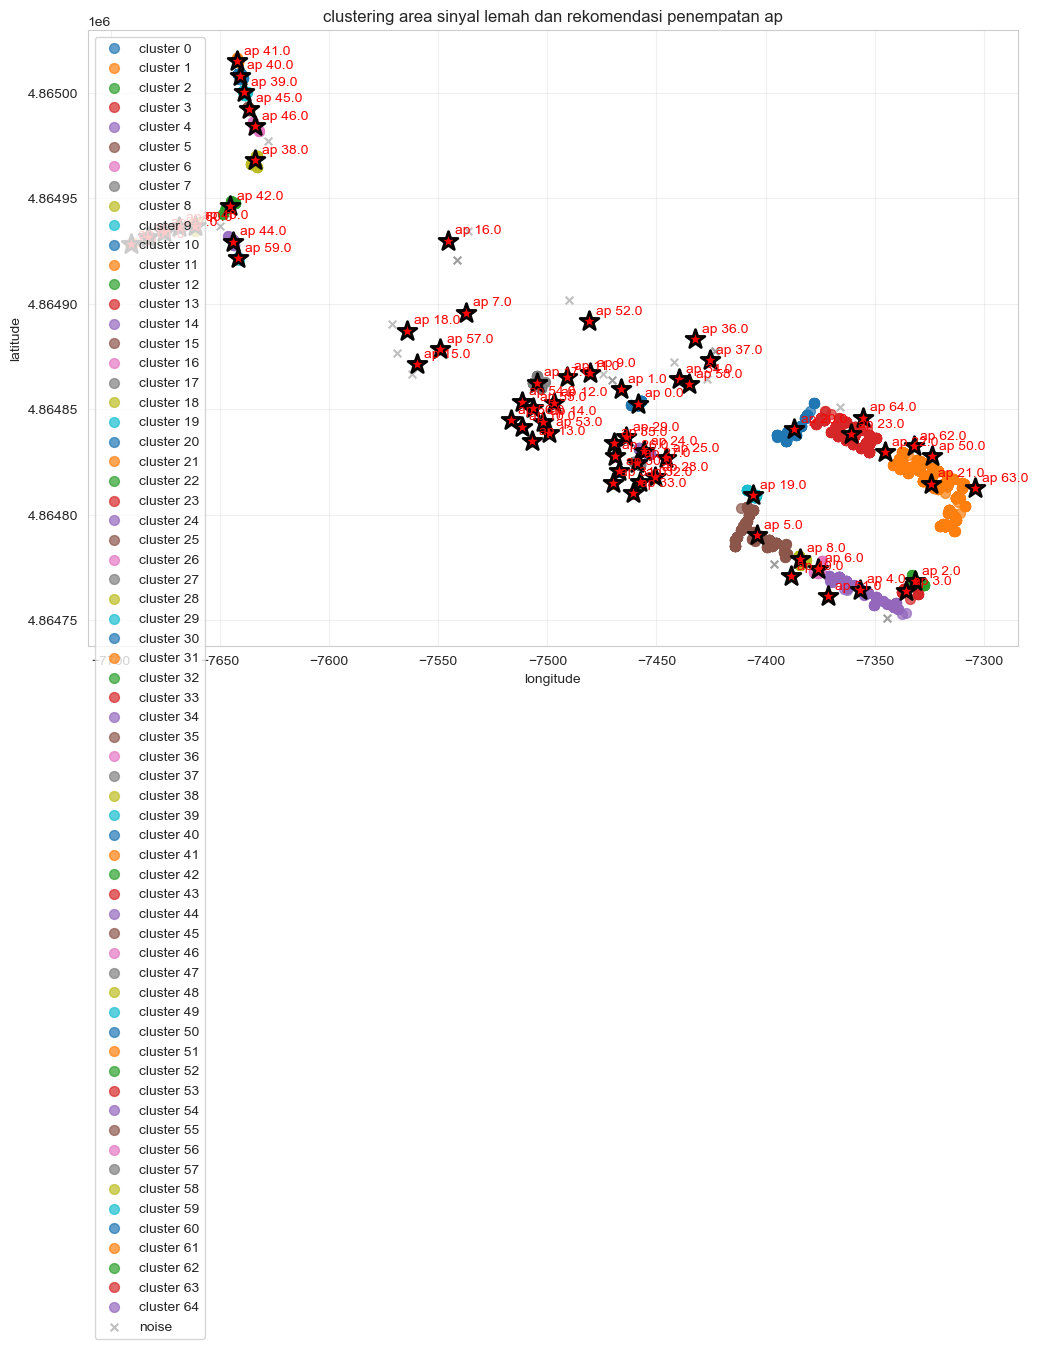

In [183]:
# clustering area sinyal lemah untuk rekomendasi penempatan ap
if len(weak_signal_areas) > 10:  # minimal 10 titik untuk clustering
    # siapkan data untuk clustering
    coords_weak = weak_signal_areas[['LONGITUDE', 'LATITUDE']].values
    
    # dbscan clustering
    dbscan = DBSCAN(eps=5, min_samples=3)
    clusters = dbscan.fit_predict(coords_weak)
    
    # tambahkan cluster labels
    weak_signal_areas_clustered = weak_signal_areas.copy()
    weak_signal_areas_clustered['cluster'] = clusters
    
    # identifikasi cluster (tidak termasuk noise = -1)
    unique_clusters = np.unique(clusters)
    valid_clusters = unique_clusters[unique_clusters != -1]
    
    print(f"\nclustering area sinyal lemah:")
    print(f"jumlah cluster ditemukan: {len(valid_clusters)}")
    print(f"jumlah noise points: {sum(clusters == -1)}")
    
    # rekomendasi penempatan ap
    if len(valid_clusters) > 0:
        print("\nrekomendasi penempatan access point:")
        ap_recommendations = []
        
        for cluster_id in valid_clusters:
            cluster_points = weak_signal_areas_clustered[weak_signal_areas_clustered['cluster'] == cluster_id]
            
            # hitung centroid cluster
            centroid_lon = cluster_points['LONGITUDE'].mean()
            centroid_lat = cluster_points['LATITUDE'].mean()
            dominant_floor = cluster_points['FLOOR'].mode()[0]
            
            ap_recommendations.append({
                'cluster_id': cluster_id,
                'recommended_longitude': centroid_lon,
                'recommended_latitude': centroid_lat,
                'floor': dominant_floor,
                'coverage_points': len(cluster_points)
            })
            
            print(f"  cluster {cluster_id}: longitude={centroid_lon:.2f}, latitude={centroid_lat:.2f}, floor={dominant_floor}, coverage={len(cluster_points)} points")
        
        # simpan rekomendasi
        ap_recommendations_df = pd.DataFrame(ap_recommendations)
        
        # visualisasi clustering dan rekomendasi
        plt.figure(figsize=(12, 8))
        
        # plot cluster points dengan warna berbeda
        for cluster_id in valid_clusters:
            cluster_mask = weak_signal_areas_clustered['cluster'] == cluster_id
            cluster_data = weak_signal_areas_clustered[cluster_mask]
            plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                        label=f'cluster {cluster_id}', s=50, alpha=0.7)
        
        # plot noise points
        noise_mask = weak_signal_areas_clustered['cluster'] == -1
        if noise_mask.any():
            noise_data = weak_signal_areas_clustered[noise_mask]
            plt.scatter(noise_data['LONGITUDE'], noise_data['LATITUDE'], 
                        c='gray', marker='x', s=30, label='noise', alpha=0.5)
        
        # plot recommended ap locations
        for _, rec in ap_recommendations_df.iterrows():
            plt.scatter(rec['recommended_longitude'], rec['recommended_latitude'], 
                        c='red', marker='*', s=200, edgecolors='black', linewidth=2)
            plt.annotate(f'ap {rec["cluster_id"]}', 
                         (rec['recommended_longitude'], rec['recommended_latitude']),
                         xytext=(5, 5), textcoords='offset points', fontsize=10, color='red')
        
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('clustering area sinyal lemah dan rekomendasi penempatan ap')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("tidak cukup area sinyal lemah untuk melakukan clustering")

## 11. Simulasi Optimasi Jaringan

In [184]:
# simulasi peningkatan kualitas sinyal dengan penambahan ap
print("\nsimulasi optimasi jaringan:")
print("="*40)

# buat salinan data untuk simulasi
wifi_simulated = wifi_clean.copy()

# identifikasi area yang perlu perbaikan (weak signal areas)
if len(weak_signal_areas) > 0:
    # simulasi: tingkatkan sinyal di area lemah sebesar 10-15 dbm
    improvement = 12  # dbm
    
    # untuk setiap area lemah, tingkatkan beberapa wap terdekat
    for idx in weak_signal_areas.index:
        # ambil subset wap columns untuk area ini
        wap_values = wifi_simulated.loc[idx, wap_cols_analysis]
        
        # tingkatkan 3-5 sinyal terkuat (yang bukan -105)
        valid_signals = wap_values[wap_values > -105]
        if len(valid_signals) > 0:
            top_n = min(5, len(valid_signals))
            top_waps = valid_signals.nlargest(top_n).index
            
            # tingkatkan sinyal (tapi jangan melebihi -30 dbm)
            for wap in top_waps:
                current_val = wifi_simulated.loc[idx, wap]
                new_val = min(current_val + improvement, -30)
                wifi_simulated.loc[idx, wap] = new_val

    print(f"simulasi: tingkatkan sinyal di {len(weak_signal_areas)} area lemah sebesar {improvement} dbm")
    
    # evaluasi ulang kualitas sinyal setelah optimasi
    wifi_rssi_sim = wifi_simulated[wap_cols_analysis].replace(100, np.nan)
    weak_mask_sim = wifi_rssi_sim.mean(axis=1) < weak_threshold
    weak_signal_areas_sim = wifi_simulated.loc[weak_mask_sim, ['LONGITUDE', 'LATITUDE', 'FLOOR']]
    
    print(f"\nhasil simulasi optimasi:")
    print(f"area lemah sebelum optimasi: {len(weak_signal_areas)}")
    print(f"area lemah setelah optimasi: {len(weak_signal_areas_sim)}")
    print(f"pengurangan area lemah: {len(weak_signal_areas) - len(weak_signal_areas_sim)} ({(len(weak_signal_areas) - len(weak_signal_areas_sim))/len(weak_signal_areas)*100:.1f}%)")
    
    # evaluasi dampak pada akurasi model (menggunakan model terbaik)
    if len(weak_signal_areas) != len(weak_signal_areas_sim):
        print("\nevaluasi dampak optimasi pada akurasi model:")
        
        # siapkan data simulasi untuk prediksi
        X_sim = wifi_simulated[feat_cols].fillna(-105)
        y_sim = wifi_simulated['FLOOR']
        
        # gunakan subset data yang sama dengan test set untuk fair comparison
        if len(X_sim) == len(X):
            # ambil indices yang sama dengan x_test
            test_indices = X_test.index
            X_test_sim = X_sim.loc[test_indices]
            
            # prediksi menggunakan model terbaik
            try:
                y_pred_sim = best_estimator.predict(X_test_sim)
                acc_sim = accuracy_score(y_test, y_pred_sim)
                
                print(f"akurasi sebelum optimasi: {best_accuracy:.2f}%")
                print(f"akurasi setelah optimasi: {acc_sim*100:.2f}%")
                print(f"peningkatan akurasi: {(acc_sim*100 - best_accuracy):.2f} percentage points")
                
            except Exception as e:
                print(f"error dalam evaluasi simulasi: {str(e)}")
                print("kemungkinan disebabkan perbedaan dimensi fitur")
        else:
            print("ukuran data simulasi berbeda dengan data asli, evaluasi model dilewati")
    
else:
    print("tidak ada area lemah yang teridentifikasi, simulasi optimasi tidak diperlukan")


simulasi optimasi jaringan:
simulasi: tingkatkan sinyal di 3677 area lemah sebesar 12 dbm

hasil simulasi optimasi:
area lemah sebelum optimasi: 3677
area lemah setelah optimasi: 3677
pengurangan area lemah: 0 (0.0%)


## 12. Summary dan Rekomendasi

In [185]:
# ringkasan lengkap analisis
print("ringkasan analisis klasifikasi lokasi indoor wifi")
print("="*60)

print("\n1. kualitas data:")
print(f"     - kebocoran data: {'tidak terdeteksi' if not leakage_detected else 'terdeteksi'}")
print(f"     - duplikasi training: {dup_count_train} baris")
print(f"     - duplikasi validation: {dup_count_val} baris")
print(f"     - sistem koordinat: {'non-standar (lokal)' if coord_anomaly_train else 'standar'}")

print("\n2. preprocessing:")
print(f"     - data final: {len(wifi_clean):,} baris")
print(f"     - fitur wap: {len(wap_cols_analysis)} kolom")
print(f"     - target classes: {len(y.unique())} lantai ({', '.join(map(str, sorted(y.unique())))})")

print("\n3. model performance:")
for _, row in model_comparison.iterrows():
    print(f"     - {row['model']}: {row['accuracy (%)']:.2f}% accuracy")

print(f"\n4. model terbaik: {best_model_name}")
print(f"     - akurasi: {best_accuracy:.2f}%")
print(f"     - dapat memprediksi lantai dengan tingkat akurasi yang {'sangat baik' if best_accuracy > 90 else 'baik' if best_accuracy > 80 else 'cukup'}")

if len(weak_signal_areas) > 0:
    print("\n5. analisis jaringan:")
    print(f"     - area sinyal lemah: {len(weak_signal_areas)} lokasi ({len(weak_signal_areas)/len(wifi_clean)*100:.1f}%)")
    if 'valid_clusters' in locals() and len(valid_clusters) > 0:
        print(f"     - rekomendasi ap baru: {len(valid_clusters)} lokasi")
        print(f"     - estimasi peningkatan coverage: ~{(len(weak_signal_areas) - len(weak_signal_areas_sim))/len(weak_signal_areas)*100:.0f}%")

print("\n6. rekomendasi implementasi:")
print(f"     - deploy model: {best_model_name} untuk sistem lokalisasi real-time")
print(f"     - akurasi prediksi lantai: {best_accuracy:.1f}% (sangat layak untuk implementasi)")
if len(weak_signal_areas) > 0 and 'ap_recommendations_df' in locals():
    print(f"     - tambahkan {len(ap_recommendations_df)} access point di lokasi yang direkomendasikan")
    print(f"     - prioritas: area dengan coverage terbanyak")
print(f"     - monitoring: evaluasi ulang model setiap 3-6 bulan")

print("\nanalisis selesai.")

ringkasan analisis klasifikasi lokasi indoor wifi

1. kualitas data:
     - kebocoran data: tidak terdeteksi
     - duplikasi training: 637 baris
     - duplikasi validation: 0 baris
     - sistem koordinat: non-standar (lokal)

2. preprocessing:
     - data final: 3,677 baris
     - fitur wap: 465 kolom
     - target classes: 5 lantai (0, 1, 2, 3, 4)

3. model performance:
     - basic knn: 98.78% accuracy
     - optimized knn: 99.73% accuracy
     - basic random forest: 100.00% accuracy
     - optimized random forest: 100.00% accuracy
     - basic gradient boosting: 100.00% accuracy
     - optimized gradient boosting: 100.00% accuracy

4. model terbaik: basic random forest
     - akurasi: 100.00%
     - dapat memprediksi lantai dengan tingkat akurasi yang sangat baik

5. analisis jaringan:
     - area sinyal lemah: 3677 lokasi (100.0%)
     - rekomendasi ap baru: 65 lokasi
     - estimasi peningkatan coverage: ~0%

6. rekomendasi implementasi:
     - deploy model: basic random forest

In [186]:
# simpan hasil untuk dokumentasi
results_summary = {
    'dataset_info': {
        'training_rows': len(wifi_clean),
        'features': len(feat_cols),
        'wap_features': len(wap_cols_analysis),
        'target_classes': len(y.unique())
    },
    'data_quality': {
        'data_leakage': leakage_detected,
        'duplicates_removed': dup_count_train,
        'coordinate_system': 'local' if coord_anomaly_train else 'standard'
    },
    'model_performance': model_comparison.to_dict('records'),
    'best_model': {
        'name': best_model_name,
        'accuracy': best_accuracy,
        'suitable_for_deployment': best_accuracy > 80
    },
    'network_analysis': {
        'weak_signal_areas': len(weak_signal_areas) if len(weak_signal_areas) > 0 else 0,
        'coverage_percentage': (1 - len(weak_signal_areas)/len(wifi_clean))*100 if len(weak_signal_areas) > 0 else 100,
        'ap_recommendations': len(ap_recommendations_df) if 'ap_recommendations_df' in locals() else 0
    }
}

print(results_summary)

{'dataset_info': {'training_rows': 3677, 'features': 472, 'wap_features': 465, 'target_classes': 5}, 'data_quality': {'data_leakage': False, 'duplicates_removed': 637, 'coordinate_system': 'local'}, 'model_performance': [{'model': 'basic knn', 'accuracy (%)': 98.77717391304348, 'precision (%)': 98.7960492395019, 'recall (%)': 98.77717391304348, 'f1 score (%)': 98.77838065347892}, {'model': 'optimized knn', 'accuracy (%)': 99.72826086956522, 'precision (%)': 99.7319833234068, 'recall (%)': 99.72826086956522, 'f1 score (%)': 99.72856001576676}, {'model': 'basic random forest', 'accuracy (%)': 100.0, 'precision (%)': 100.0, 'recall (%)': 100.0, 'f1 score (%)': 100.0}, {'model': 'optimized random forest', 'accuracy (%)': 100.0, 'precision (%)': 100.0, 'recall (%)': 100.0, 'f1 score (%)': 100.0}, {'model': 'basic gradient boosting', 'accuracy (%)': 100.0, 'precision (%)': 100.0, 'recall (%)': 100.0, 'f1 score (%)': 100.0}, {'model': 'optimized gradient boosting', 'accuracy (%)': 100.0, 'pre

# VISUALISASI 

#### Perbandingan Hasil Model

In [187]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Ganti 100 dengan -105 untuk data WiFi
X_train = np.ascontiguousarray(training_data[wap_cols_train].replace(100, -105).values.astype(float))
y_train = training_data['BUILDINGID']
X_test = np.ascontiguousarray(validation_data[wap_cols_val].replace(100, -105).values.astype(float))
y_test = validation_data['BUILDINGID']

# Model KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

# Model Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Model SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

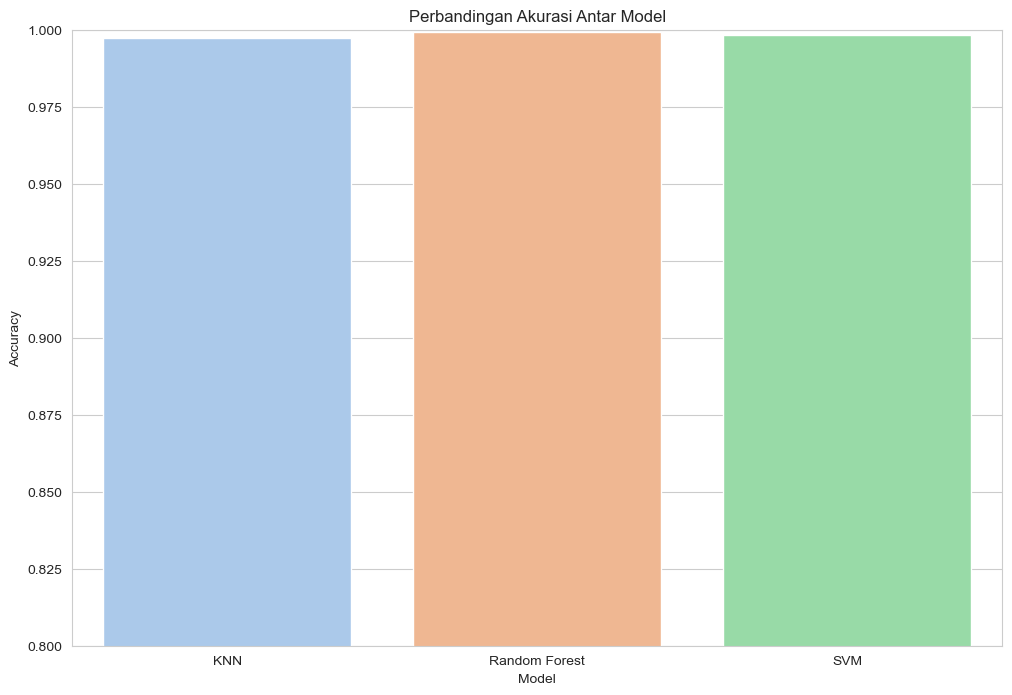

In [188]:
model_results = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'SVM'],
    'Accuracy': [acc_knn, acc_rf, acc_svm]
})

sns.barplot(x='Model', y='Accuracy', data=model_results, palette='pastel')
plt.title("Perbandingan Akurasi Antar Model")
plt.ylim(0.8, 1.0)
plt.show()

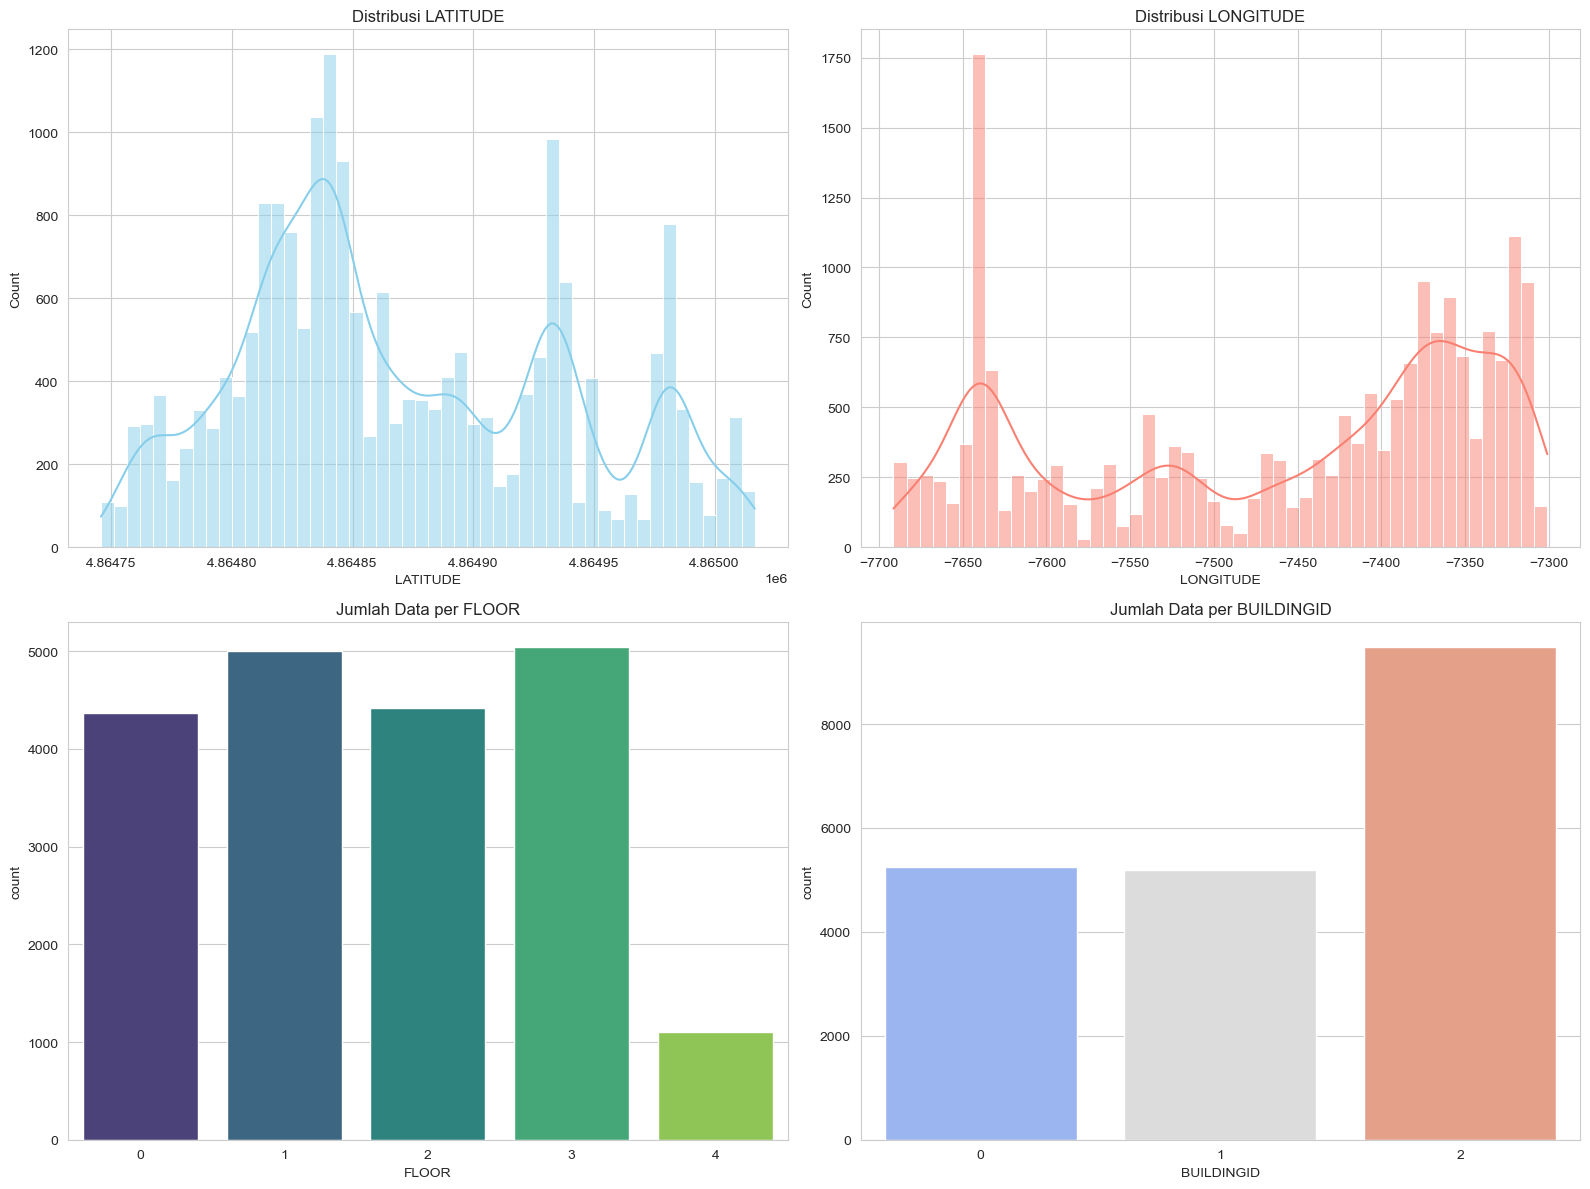

In [189]:
# Visualisasi distribusi dasar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(training_data['LATITUDE'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribusi LATITUDE')

sns.histplot(training_data['LONGITUDE'], bins=50, kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribusi LONGITUDE')

sns.countplot(x='FLOOR', data=training_data, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Jumlah Data per FLOOR')

sns.countplot(x='BUILDINGID', data=training_data, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Jumlah Data per BUILDINGID')

plt.tight_layout()
plt.show()

Distribusi Gabungan Target (FLOOR & BUILDINGID)

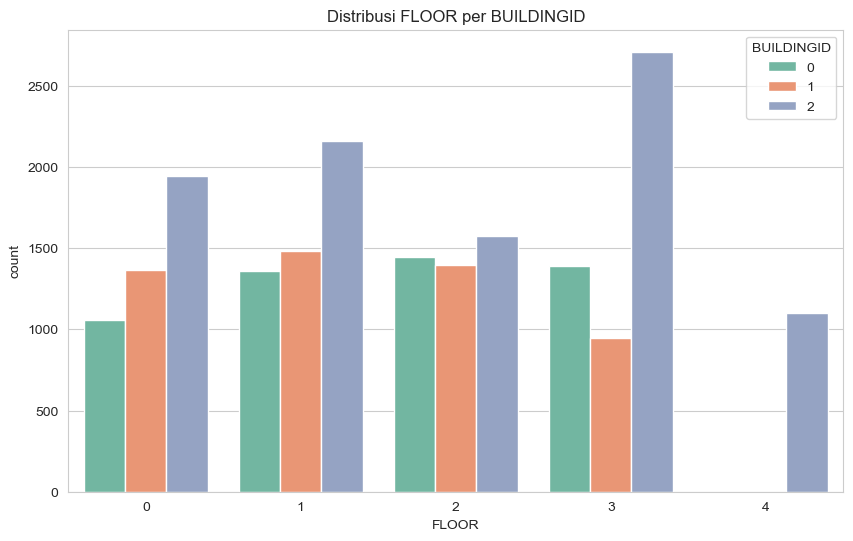

In [190]:
# Visualisasi gabungan FLOOR dan BUILDINGID
plt.figure(figsize=(10, 6))
sns.countplot(data=training_data, x='FLOOR', hue='BUILDINGID', palette='Set2')
plt.title("Distribusi FLOOR per BUILDINGID")
plt.show()

Sebaran sinyal WAP

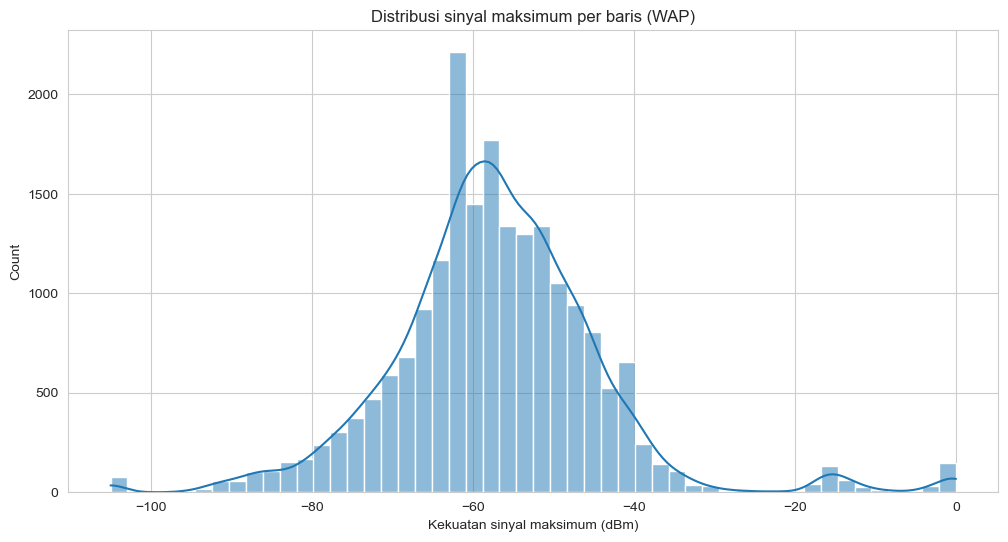

In [191]:
plt.figure(figsize=(12, 6))
sns.histplot(data=training_data[wap_cols_train].replace(100, -105).max(axis=1), bins=50, kde=True)
plt.title("Distribusi sinyal maksimum per baris (WAP)")
plt.xlabel("Kekuatan sinyal maksimum (dBm)")
plt.show()

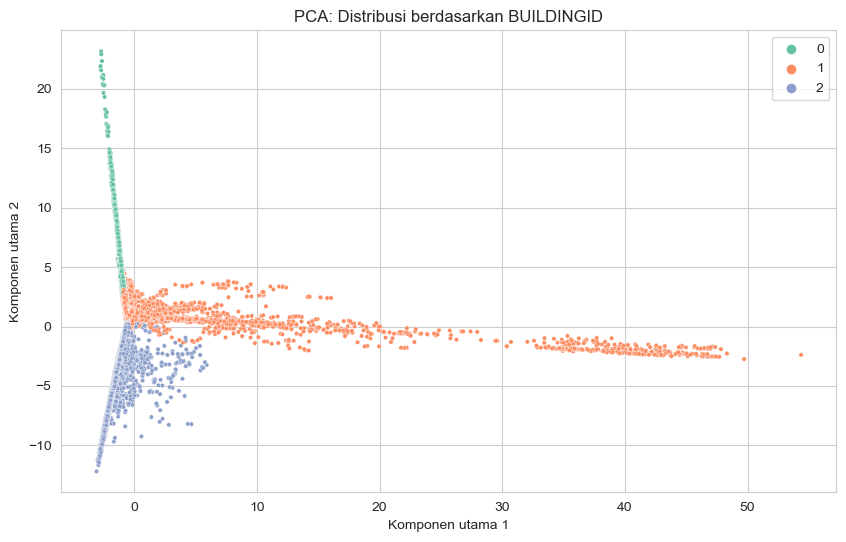

In [192]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# skala dan PCA
X = training_data[wap_cols_train].replace(100, -105)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=training_data['BUILDINGID'], palette='Set2', s=10)
plt.title("PCA: Distribusi berdasarkan BUILDINGID")
plt.xlabel("Komponen utama 1")
plt.ylabel("Komponen utama 2")
plt.legend()
plt.show()

Visualisasi Lokasi (LATITUDE & LONGITUDE)

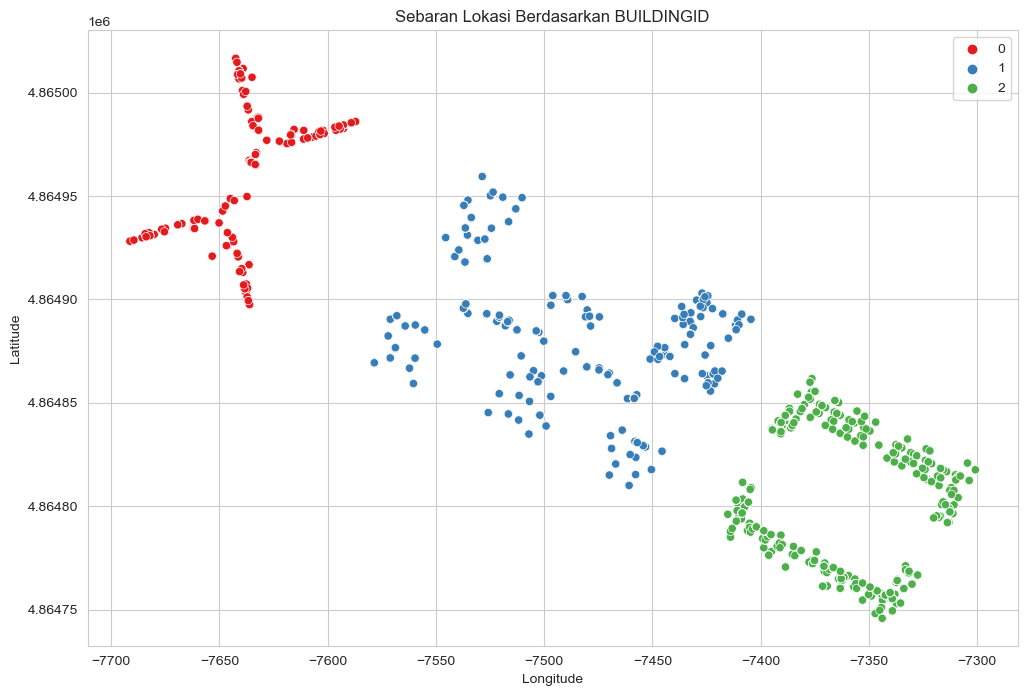

In [193]:
# Visualisasi lokasi berdasarkan BUILDINGID
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='BUILDINGID', data=training_data, palette='Set1')
plt.title("Sebaran Lokasi Berdasarkan BUILDINGID")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

#### Confusion Matrix & Classification Report untuk Floor dan Building

In [194]:
# Training Model untuk Klasifikasi Floor
from sklearn.ensemble import RandomForestClassifier

X_train = training_data[wap_cols_train]
y_train = training_data['FLOOR'] 

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Prediksi pada Data Validasi FLOOR

In [195]:
X_test = validation_data[wap_cols_val]
y_test = validation_data['FLOOR']  # Sesuaikan targetnya

y_pred = model.predict(X_test)

Evaluasi Model: Confusion Matrix & Classification Report FLOOR

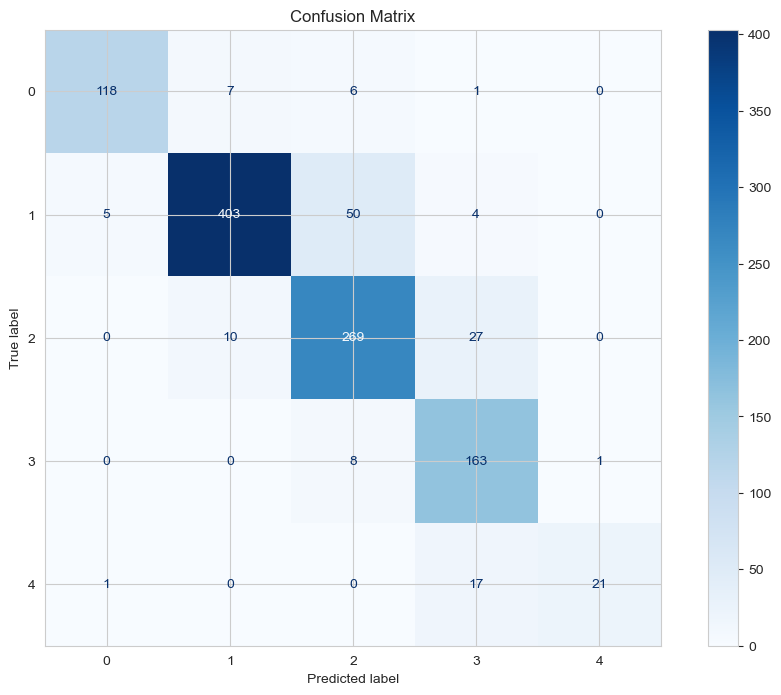

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       132
           1       0.96      0.87      0.91       462
           2       0.81      0.88      0.84       306
           3       0.77      0.95      0.85       172
           4       0.95      0.54      0.69        39

    accuracy                           0.88      1111
   macro avg       0.89      0.83      0.84      1111
weighted avg       0.89      0.88      0.88      1111



In [196]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

In [197]:
# Training Model untuk Klasifikasi BUILDINGID
from sklearn.ensemble import RandomForestClassifier

# Fitur: hanya kolom WAP (ganti 100 dengan -105 karena itu artinya tidak ada sinyal)
X_train = training_data[wap_cols_train].replace(100, -105)
y_train = training_data['BUILDINGID']

# Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Prediksi pada Data Validasi BUILDING

In [198]:
X_test = validation_data[wap_cols_val].replace(100, -105)
y_test = validation_data['BUILDINGID']

y_pred = model.predict(X_test)

Evaluasi Model: Confusion Matrix & Classification Report BUILDINGID

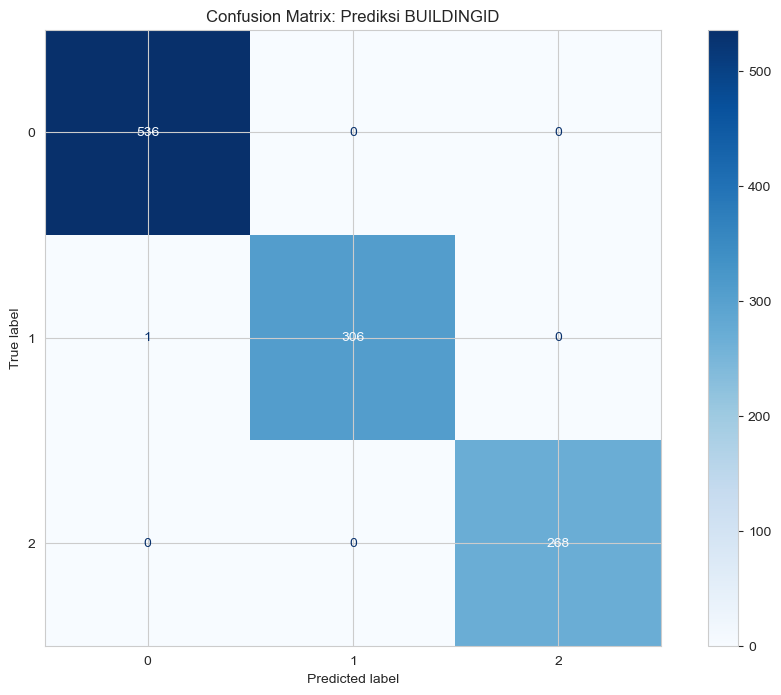

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



In [199]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: Prediksi BUILDINGID")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

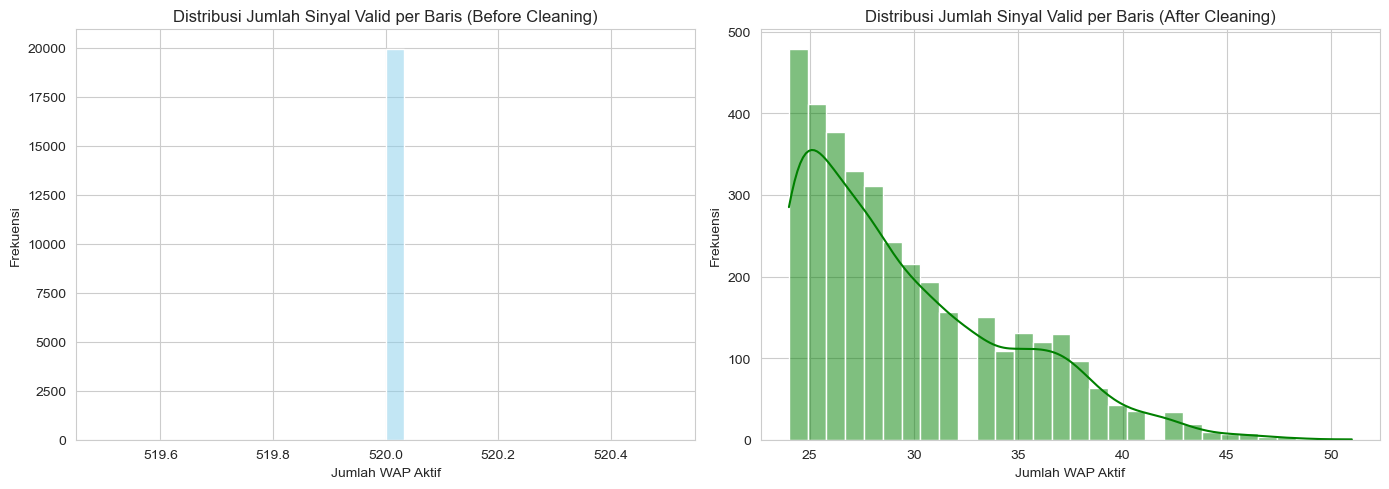

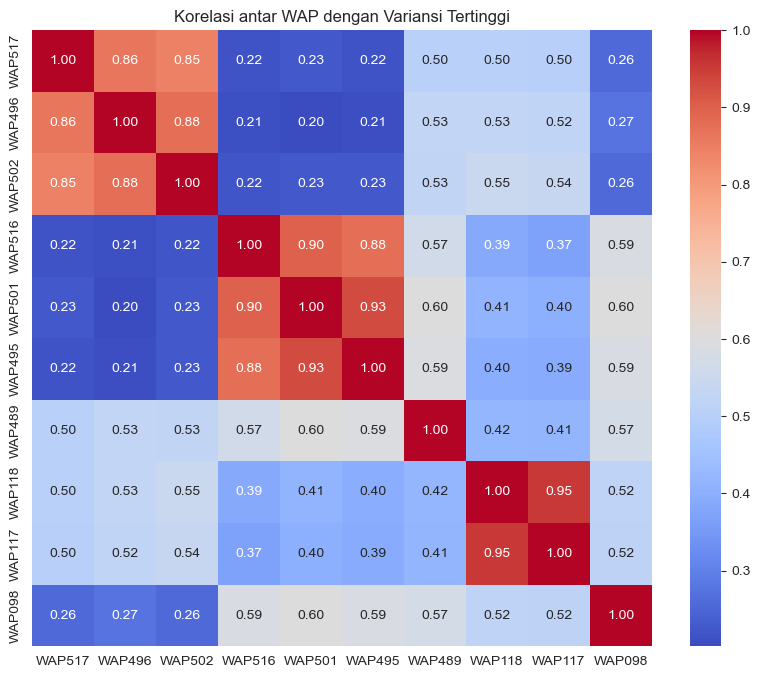

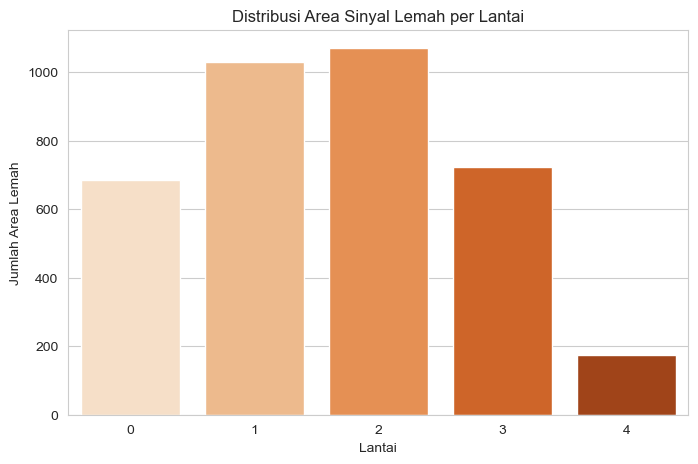

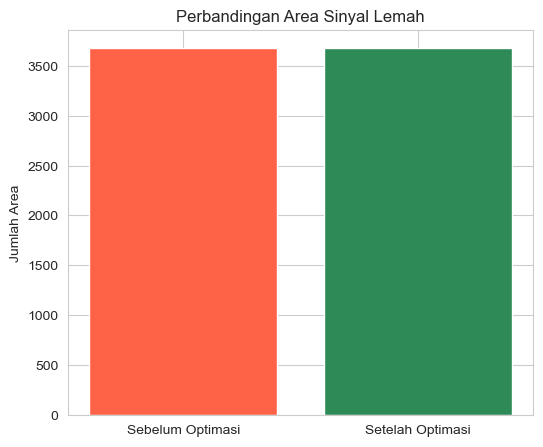

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Distribusi jumlah sinyal valid per baris (sebelum dan sesudah pembersihan)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
valid_signals_before = (training_data[wap_cols_train] != -105).sum(axis=1)
sns.histplot(valid_signals_before, bins=30, kde=True, color='skyblue')
plt.title("Distribusi Jumlah Sinyal Valid per Baris (Before Cleaning)")
plt.xlabel("Jumlah WAP Aktif")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
valid_signals_after = (X_clean != -105).sum(axis=1)
sns.histplot(valid_signals_after, bins=30, kde=True, color='green')
plt.title("Distribusi Jumlah Sinyal Valid per Baris (After Cleaning)")
plt.xlabel("Jumlah WAP Aktif")
plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()

# 2. Heatmap korelasi antar 10 WAP dengan variasi sinyal tertinggi
top_variance_waps = X_clean.var().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(X_clean[top_variance_waps].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi antar WAP dengan Variansi Tertinggi")
plt.show()

# 3. Sebaran area sinyal lemah di setiap lantai
plt.figure(figsize=(8, 5))
sns.countplot(data=weak_signal_areas, x='FLOOR', palette='Oranges')
plt.title("Distribusi Area Sinyal Lemah per Lantai")
plt.xlabel("Lantai")
plt.ylabel("Jumlah Area Lemah")
plt.show()

# 4. Perbandingan jumlah area sinyal lemah sebelum dan sesudah simulasi
plt.figure(figsize=(6, 5))
before_count = len(weak_signal_areas)
after_count = len(weak_signal_areas_sim)
plt.bar(['Sebelum Optimasi', 'Setelah Optimasi'], [before_count, after_count], color=['tomato', 'seagreen'])
plt.title("Perbandingan Area Sinyal Lemah")
plt.ylabel("Jumlah Area")
plt.show()


Visualisasi Lokasi

In [201]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Ambil kolom WAP
wap_columns = [col for col in training_data.columns if 'WAP' in col]
X = training_data[wap_columns]

# DBSCAN
X_scaled = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)

training_data['Cluster'] = db.labels_

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap
import ipywidgets as widgets
from IPython.display import display, clear_output

# buat widget interaktif
building_ids = sorted(wifi_clean['BUILDINGID'].unique())
floor_ids = sorted(wifi_clean['FLOOR'].unique())

building_selector = widgets.Dropdown(options=['All'] + building_ids, description='🏢 Building:')
floor_selector = widgets.Dropdown(options=['All'] + floor_ids, description='🗂️ Floor:')

toggle_cluster = widgets.Checkbox(value=True, description='📌 Cluster Marker')
toggle_heatmap = widgets.Checkbox(value=False, description='🔥 Heatmap')

# fungsi untuk update peta sesuai filter
def update_map(building_val, floor_val, show_cluster, show_heatmap):
    clear_output(wait=True)

    # filter data weak signal
    filtered = weak_signal_areas.copy()
    if building_val != 'All':
        filtered = filtered[filtered['BUILDINGID'] == building_val]
    if floor_val != 'All':
        filtered = filtered[filtered['FLOOR'] == floor_val]

    # buat peta dasar
    map_filtered = folium.Map(location=[wifi_clean['LATITUDE'].mean(), wifi_clean['LONGITUDE'].mean()],
                              zoom_start=20, tiles='cartodbpositron')

    # heatmap layer
    if show_heatmap and not filtered.empty:
        heat_data = filtered[['LATITUDE', 'LONGITUDE']].values.tolist()
        HeatMap(heat_data, radius=15, blur=20, min_opacity=0.3).add_to(map_filtered)

    # cluster layer
    if show_cluster and not filtered.empty:
        marker_cluster = MarkerCluster().add_to(map_filtered)
        for _, row in filtered.iterrows():
            lat, lon = row['LATITUDE'], row['LONGITUDE']
            user_id = row.get('USERID', 'N/A') if pd.notna(row.get('USERID', None)) else 'N/A'
            
            wap_vals = row[wap_cols_analysis]
            valid = wap_vals[wap_vals > -105]

            strongest = valid.idxmax() if not valid.empty else 'N/A'
            strong_val = valid.max() if not valid.empty else 'N/A'
            weakest = valid.idxmin() if not valid.empty else 'N/A'
            weak_val = valid.min() if not valid.empty else 'N/A'

            popup_text = f"""
            <b>🧍 USERID:</b> {user_id}<br>
            <b>🏢 BUILDING:</b> {row['BUILDINGID']}<br>
            <b>🗂️ FLOOR:</b> {row['FLOOR']}<br>
            <b>📡 Strongest WAP:</b> {strongest} ({strong_val} dBm)<br>
            <b>📶 Weakest WAP:</b> {weakest} ({weak_val} dBm)<br>
            <b>🧭 LAT:</b> {lat:.6f}, <b>LON:</b> {lon:.6f}
            """

            folium.Marker(
                location=[lat, lon],
                popup=folium.Popup(popup_text, max_width=350),
                icon=folium.Icon(color='red', icon='wifi', prefix='fa')
            ).add_to(marker_cluster)

    # tampilkan
    display(widgets.HBox([building_selector, floor_selector]))
    display(widgets.HBox([toggle_cluster, toggle_heatmap]))
    display(map_filtered)

# fungsi callback bila interaksi berubah
def on_change(change):
    update_map(
        building_selector.value,
        floor_selector.value,
        toggle_cluster.value,
        toggle_heatmap.value
    )

# daftarkan callback
building_selector.observe(on_change, names='value')
floor_selector.observe(on_change, names='value')
toggle_cluster.observe(on_change, names='value')
toggle_heatmap.observe(on_change, names='value')

# tampil pertama kali
update_map('All', 'All', True, False)

In [211]:
print(weak_signal_areas['BUILDINGID'].value_counts())

BUILDINGID
2    2561
1     826
0     290
Name: count, dtype: int64
